In [46]:
import pandas as pd
import numpy as np
import regex as re
import datetime
import nltk
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords

import multiprocessing
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.decomposition import LatentDirichletAllocation as LDA

In [4]:
# merged_df = pd.read_csv('../data/merged_data.csv')

In [5]:
filtered_df = pd.read_csv('../data/merged_filtered_articles.csv')

In [6]:
filtered_df.shape

(15549, 10)

## Checking for Null Values

In [7]:
filtered_df.isnull().sum()

source             0
title              0
abstract        2142
publish_time       0
authors           69
journal         2994
url              111
paper_id           0
discussion      8597
text_body          0
dtype: int64

In [8]:
# merged_df.isnull().sum()

In [9]:
filtered_df.isnull().sum()

source             0
title              0
abstract        2142
publish_time       0
authors           69
journal         2994
url              111
paper_id           0
discussion      8597
text_body          0
dtype: int64

## Average Length of Sections and Deal With Null Values

In [10]:
print('abstract:', round(filtered_df['abstract'].str.len().mean(), 2))
print('discussion:', round(filtered_df['discussion'].str.len().mean(), 2))
print('text_body:', round(filtered_df['text_body'].str.len().mean(), 2))

abstract: 1369.56
discussion: 5675.4
text_body: 17616.58


In [11]:
# 2045 are missing both abstract and discussion 
# filtered_df[(filtered_df['discussion'].isnull() )& (filtered_df['abstract'].isnull())]

In [12]:
filtered_df.loc[pd.isnull(filtered_df['abstract']), 'abstract'] = filtered_df['text_body']

In [13]:
filtered_df.loc[pd.isnull(filtered_df['discussion']), 'discussion'] = filtered_df['text_body']

In [14]:
filtered_df.drop(columns=['source', 'journal', 'url', 'authors'], inplace=True)

In [15]:
filtered_df.isnull().sum()

title           0
abstract        0
publish_time    0
paper_id        0
discussion      0
text_body       0
dtype: int64

## Cleaning Data

In [16]:
def word_count(series):
    list_tokens = [w.lower() for w in series]
    string_tokens = str(list_tokens)
    return string_tokens

len(word_count(filtered_df['abstract']).split())

5010368

In [17]:
stop_words = stopwords.words('english')
word_tokenizer = RegexpTokenizer(('\w+|\$[\d\.]+|\S+'))
# unless attached to numeric digit

lemmatize = WordNetLemmatizer()

def clean_words(series): 
    cdf = series
    # lower all words
    cdf = cdf.apply(lambda x: x.lower())
    
    # remove puctuation 
    cdf = cdf.apply(lambda x: re.sub('[^a-zA-Z0-9]+',' ', x))
    
    # remove special characters and digits
#     cdf = cdf.apply(lambda x: re.sub('(\d|\W)+', ' ', x))
    
  # remove letter single words
    cdf = cdf.apply(lambda x: re.sub(r'\b[a-zA-Z]\b', ' ', x))
    
    # tokenizer
    cdf = cdf.apply(lambda x: word_tokenize(x))
    count_pre = cdf.apply(lambda x: len(x))
    cdf = cdf.apply(lambda x: [i for i in x if not i in stop_words])
    
    # lem
    cdf = cdf.apply(lambda x: [lemmatize.lemmatize(i) for i in x])
    count_post = cdf.apply(lambda x: len(x))
    cdf = cdf.apply(lambda x: ' '.join(x))
    
    return cdf

In [18]:
filtered_df['abstract_clean'] = clean_words(filtered_df['abstract'])

In [120]:
# bag of words for clean abstract 
clean_text = [i.split() for i in filtered_df['abstract_clean']]

In [19]:
# print(filtered_df['title'][5])
# print(clean_words(filtered_df['title'])[5])
print(filtered_df['title'][814])
print(clean_words(filtered_df['title'])[814])
print(filtered_df['title'][72])
print(clean_words(filtered_df['title'])[72])
print(filtered_df['title'][63])
print(clean_words(filtered_df['title'])[63])

Multi-omic network signatures of disease
multi omic network signature disease
Using simulation for training and to change protocol during the outbreak of severe acute respiratory syndrome
using simulation training change protocol outbreak severe acute respiratory syndrome
Specific detection of H5N1 avian influenza A virus in field specimens by a one-step RT-PCR assay
specific detection h5n1 avian influenza virus field specimen one step rt pcr assay


In [20]:
filtered_df.head()

,title,abstract,publish_time,paper_id,discussion,text_body,abstract_clean
0,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,e3d0d482ebd9a8ba81c254cc433f314142e72174,Carcinoembryonic antigen (CEA; CD66e) was init...,Carcinoembryonic antigen (CEA; CD66e) was init...,ceacam1 member carcinoembryonic antigen cea fa...
1,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,Transmissible gastroenteritis virus (TGEV) bel...,Transmissible gastroenteritis virus (TGEV) bel...,key enzyme coronavirus polyprotein processing ...
2,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,0104f6ceccf92ae8567a0102f89cbb976969a774,HLA-B gene was found to be associated with sus...,"patient group, a further significant increase ...",background human leukocyte antigen hla system ...
3,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,5b68a553a7cbbea13472721cd1ad617d42b40c26,The Severe Acute Respiratory Syndrome outbreak...,Since November 2002 (and perhaps earlier) an o...,background epidemic severe acute respiratory s...
4,Cloaked similarity between HIV-1 and SARS-CoV ...,BACKGROUND: Severe acute respiratory syndrome ...,2003-09-21,3ed670f60a7be2e3e2a991ea8af1fdd5fa5e2b2c,Infection by many enveloped viruses requires f...,Infection by many enveloped viruses requires f...,background severe acute respiratory syndrome s...


In [21]:
filtered_df['publish_time'] = pd.to_datetime(filtered_df['publish_time'])

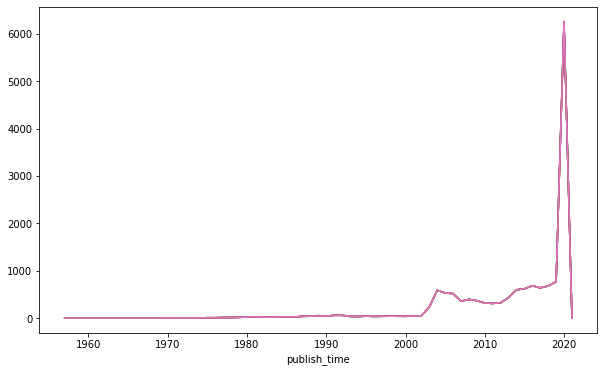

In [23]:
filtered_df.groupby(filtered_df['publish_time'].dt.year).count().plot(kind='line', figsize=(10,6), legend=False);                                                                   

## Word2Vec

In [24]:
pip install -U spacy

Requirement already up-to-date: spacy in /Users/jobethschroeter/opt/anaconda3/envs/dsi/lib/python3.7/site-packages (2.2.4)
Note: you may need to restart the kernel to use updated packages.


In [25]:
from time import time
import spacy
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [26]:
# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [27]:
# list of sentences 
sent = [row.split() for row in filtered_df['abstract_clean']]

In [28]:
#sent_2 = [row.split() for row in filtered_df['abstract']]

In [29]:
#phrases = Phrases(sent_2, min_count=30, progress_per=10000)

In [30]:
# creates relevant phrases from list of sentences 
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 22:01:14: collecting all words and their counts
INFO - 22:01:14: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 22:01:19: PROGRESS: at sentence #10000, processed 2317087 words and 1176088 word types
INFO - 22:01:22: collected 1556085 word types from a corpus of 3395304 words (unigram + bigrams) and 15549 sentences
INFO - 22:01:22: using 1556085 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [31]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=3)

In [32]:
t = time()
w2v_model.build_vocab(sent, progress_per=10000)

INFO - 22:01:22: collecting all words and their counts
INFO - 22:01:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:01:23: PROGRESS: at sentence #10000, processed 2317087 words, keeping 68412 word types
INFO - 22:01:23: collected 82471 word types from a corpus of 3395304 raw words and 15549 sentences
INFO - 22:01:23: Loading a fresh vocabulary
INFO - 22:01:23: effective_min_count=20 retains 10762 unique words (13% of original 82471, drops 71709)
INFO - 22:01:23: effective_min_count=20 leaves 3173583 word corpus (93% of original 3395304, drops 221721)
INFO - 22:01:23: deleting the raw counts dictionary of 82471 items
INFO - 22:01:23: sample=6e-05 downsamples 1234 most-common words
INFO - 22:01:23: downsampling leaves estimated 1794461 word corpus (56.5% of prior 3173583)
INFO - 22:01:24: estimated required memory for 10762 words and 300 dimensions: 31209800 bytes
INFO - 22:01:24: resetting layer weights


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
train, test = train_test_split(filtered_df['abstract_clean'], test_size = 0.2)

In [103]:
cvec = CountVectorizer()

train_cvec = cvec.fit_transform(train)
test_cvec = cvec.transform(test)


In [54]:
Z_model = w2v_model.train(train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

WARNING - 22:30:17: Effective 'alpha' higher than previous training cycles
INFO - 22:30:17: training model with 3 workers on 10762 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 22:30:18: EPOCH 1 - PROGRESS: at 1.23% examples, 164635 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:19: EPOCH 1 - PROGRESS: at 3.56% examples, 243045 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:20: EPOCH 1 - PROGRESS: at 6.04% examples, 282354 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:21: EPOCH 1 - PROGRESS: at 8.71% examples, 302118 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:22: EPOCH 1 - PROGRESS: at 10.78% examples, 305355 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:23: EPOCH 1 - PROGRESS: at 12.92% examples, 314026 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:24: EPOCH 1 - PROGRESS: at 15.36% examples, 323527 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:26: EPOCH 1 - PROGRESS: at 17.60% examples, 329005 words/s, in_qsize 5, out_qsize 0
INFO - 22:30:27: E

INFO - 22:31:35: EPOCH 3 - PROGRESS: at 26.63% examples, 331751 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:36: EPOCH 3 - PROGRESS: at 29.16% examples, 335651 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:37: EPOCH 3 - PROGRESS: at 31.55% examples, 338803 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:38: EPOCH 3 - PROGRESS: at 34.10% examples, 342446 words/s, in_qsize 4, out_qsize 1
INFO - 22:31:39: EPOCH 3 - PROGRESS: at 36.46% examples, 345477 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:40: EPOCH 3 - PROGRESS: at 39.17% examples, 349027 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:41: EPOCH 3 - PROGRESS: at 41.71% examples, 349315 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:42: EPOCH 3 - PROGRESS: at 44.70% examples, 354137 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:43: EPOCH 3 - PROGRESS: at 47.57% examples, 355684 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:44: EPOCH 3 - PROGRESS: at 49.96% examples, 355707 words/s, in_qsize 5, out_qsize 0
INFO - 22:31:45: EPOCH 3 - PRO

INFO - 22:32:53: EPOCH 5 - PROGRESS: at 65.43% examples, 379703 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:54: EPOCH 5 - PROGRESS: at 67.16% examples, 374539 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:55: EPOCH 5 - PROGRESS: at 68.47% examples, 368498 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:56: EPOCH 5 - PROGRESS: at 70.44% examples, 365317 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:57: EPOCH 5 - PROGRESS: at 72.25% examples, 362385 words/s, in_qsize 5, out_qsize 1
INFO - 22:32:58: EPOCH 5 - PROGRESS: at 73.72% examples, 358473 words/s, in_qsize 5, out_qsize 0
INFO - 22:32:59: EPOCH 5 - PROGRESS: at 75.66% examples, 356292 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:00: EPOCH 5 - PROGRESS: at 77.43% examples, 352150 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:01: EPOCH 5 - PROGRESS: at 78.84% examples, 347463 words/s, in_qsize 5, out_qsize 0
INFO - 22:33:02: worker thread finished; awaiting finish of 2 more threads
INFO - 22:33:02: worker thread finished; awaiting fi

INFO - 22:34:12: EPOCH 7 - PROGRESS: at 71.87% examples, 288164 words/s, in_qsize 5, out_qsize 0
INFO - 22:34:13: EPOCH 7 - PROGRESS: at 74.35% examples, 290747 words/s, in_qsize 5, out_qsize 0
INFO - 22:34:14: EPOCH 7 - PROGRESS: at 76.37% examples, 291098 words/s, in_qsize 5, out_qsize 0
INFO - 22:34:15: EPOCH 7 - PROGRESS: at 78.16% examples, 289829 words/s, in_qsize 5, out_qsize 0
INFO - 22:34:16: worker thread finished; awaiting finish of 2 more threads
INFO - 22:34:16: worker thread finished; awaiting finish of 1 more threads
INFO - 22:34:16: worker thread finished; awaiting finish of 0 more threads
INFO - 22:34:16: EPOCH - 7 : training on 20402153 raw words (12113233 effective words) took 41.8s, 289914 effective words/s
WARNING - 22:34:16: EPOCH - 7 : supplied example count (12439) did not equal expected count (15549)
INFO - 22:34:17: EPOCH 8 - PROGRESS: at 2.24% examples, 305084 words/s, in_qsize 5, out_qsize 0
INFO - 22:34:18: EPOCH 8 - PROGRESS: at 4.46% examples, 299791 word

INFO - 22:35:31: EPOCH 9 - PROGRESS: at 56.90% examples, 272818 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:32: EPOCH 9 - PROGRESS: at 58.63% examples, 273308 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:33: EPOCH 9 - PROGRESS: at 60.35% examples, 272614 words/s, in_qsize 4, out_qsize 1
INFO - 22:35:34: EPOCH 9 - PROGRESS: at 62.80% examples, 275369 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:35: EPOCH 9 - PROGRESS: at 65.03% examples, 278014 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:36: EPOCH 9 - PROGRESS: at 66.96% examples, 277449 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:37: EPOCH 9 - PROGRESS: at 68.83% examples, 277583 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:38: EPOCH 9 - PROGRESS: at 71.70% examples, 281438 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:39: EPOCH 9 - PROGRESS: at 73.86% examples, 283195 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:40: EPOCH 9 - PROGRESS: at 75.28% examples, 281985 words/s, in_qsize 5, out_qsize 0
INFO - 22:35:41: EPOCH 9 - PRO

INFO - 22:36:49: EPOCH 11 - PROGRESS: at 59.32% examples, 315552 words/s, in_qsize 6, out_qsize 0
INFO - 22:36:50: EPOCH 11 - PROGRESS: at 60.31% examples, 309598 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:51: EPOCH 11 - PROGRESS: at 61.41% examples, 305058 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:52: EPOCH 11 - PROGRESS: at 62.63% examples, 301023 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:53: EPOCH 11 - PROGRESS: at 64.13% examples, 300236 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:54: EPOCH 11 - PROGRESS: at 66.35% examples, 300250 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:55: EPOCH 11 - PROGRESS: at 68.37% examples, 300372 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:56: EPOCH 11 - PROGRESS: at 70.08% examples, 298734 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:57: EPOCH 11 - PROGRESS: at 72.05% examples, 298631 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:58: EPOCH 11 - PROGRESS: at 73.82% examples, 298473 words/s, in_qsize 5, out_qsize 0
INFO - 22:36:59: EPO

INFO - 22:38:05: EPOCH 13 - PROGRESS: at 66.88% examples, 385788 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:06: EPOCH 13 - PROGRESS: at 69.52% examples, 385714 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:07: EPOCH 13 - PROGRESS: at 72.11% examples, 385719 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:08: EPOCH 13 - PROGRESS: at 74.87% examples, 387767 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:09: EPOCH 13 - PROGRESS: at 77.67% examples, 387735 words/s, in_qsize 5, out_qsize 0
INFO - 22:38:10: worker thread finished; awaiting finish of 2 more threads
INFO - 22:38:10: worker thread finished; awaiting finish of 1 more threads
INFO - 22:38:10: worker thread finished; awaiting finish of 0 more threads
INFO - 22:38:10: EPOCH - 13 : training on 20402153 raw words (12111956 effective words) took 31.2s, 387900 effective words/s
WARNING - 22:38:10: EPOCH - 13 : supplied example count (12439) did not equal expected count (15549)
INFO - 22:38:11: EPOCH 14 - PROGRESS: at 2.86% examples, 38

WARNING - 22:39:19: EPOCH - 15 : supplied example count (12439) did not equal expected count (15549)
INFO - 22:39:20: EPOCH 16 - PROGRESS: at 2.36% examples, 330913 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:21: EPOCH 16 - PROGRESS: at 5.11% examples, 352809 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:22: EPOCH 16 - PROGRESS: at 8.00% examples, 374193 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:23: EPOCH 16 - PROGRESS: at 10.82% examples, 386655 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:24: EPOCH 16 - PROGRESS: at 13.09% examples, 379843 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:25: EPOCH 16 - PROGRESS: at 15.25% examples, 369994 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:26: EPOCH 16 - PROGRESS: at 16.64% examples, 353698 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:27: EPOCH 16 - PROGRESS: at 18.23% examples, 340577 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:28: EPOCH 16 - PROGRESS: at 19.67% examples, 326504 words/s, in_qsize 5, out_qsize 0
INFO - 22:39:29: EPO

INFO - 22:40:37: EPOCH 18 - PROGRESS: at 15.69% examples, 383083 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:38: EPOCH 18 - PROGRESS: at 18.21% examples, 388031 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:39: EPOCH 18 - PROGRESS: at 20.75% examples, 387201 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:40: EPOCH 18 - PROGRESS: at 23.52% examples, 391719 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:41: EPOCH 18 - PROGRESS: at 26.10% examples, 390883 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:42: EPOCH 18 - PROGRESS: at 28.88% examples, 391162 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:43: EPOCH 18 - PROGRESS: at 31.23% examples, 390798 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:44: EPOCH 18 - PROGRESS: at 33.95% examples, 392976 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:45: EPOCH 18 - PROGRESS: at 36.40% examples, 393779 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:46: EPOCH 18 - PROGRESS: at 39.02% examples, 393435 words/s, in_qsize 5, out_qsize 0
INFO - 22:40:47: EPO

INFO - 22:41:54: EPOCH 20 - PROGRESS: at 46.85% examples, 389094 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:55: EPOCH 20 - PROGRESS: at 49.29% examples, 389337 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:56: EPOCH 20 - PROGRESS: at 52.09% examples, 390803 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:57: EPOCH 20 - PROGRESS: at 54.61% examples, 390641 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:58: EPOCH 20 - PROGRESS: at 57.46% examples, 391472 words/s, in_qsize 5, out_qsize 0
INFO - 22:41:59: EPOCH 20 - PROGRESS: at 60.08% examples, 392292 words/s, in_qsize 5, out_qsize 0
INFO - 22:42:00: EPOCH 20 - PROGRESS: at 62.74% examples, 391987 words/s, in_qsize 5, out_qsize 0
INFO - 22:42:01: EPOCH 20 - PROGRESS: at 65.10% examples, 392155 words/s, in_qsize 5, out_qsize 0
INFO - 22:42:02: EPOCH 20 - PROGRESS: at 67.86% examples, 391980 words/s, in_qsize 5, out_qsize 0
INFO - 22:42:03: EPOCH 20 - PROGRESS: at 70.61% examples, 391573 words/s, in_qsize 5, out_qsize 0
INFO - 22:42:04: EPO

INFO - 22:43:08: worker thread finished; awaiting finish of 0 more threads
INFO - 22:43:08: EPOCH - 22 : training on 20402153 raw words (12113809 effective words) took 30.7s, 394442 effective words/s
WARNING - 22:43:08: EPOCH - 22 : supplied example count (12439) did not equal expected count (15549)
INFO - 22:43:09: EPOCH 23 - PROGRESS: at 2.73% examples, 370375 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:10: EPOCH 23 - PROGRESS: at 5.71% examples, 393353 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:11: EPOCH 23 - PROGRESS: at 8.50% examples, 393209 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:12: EPOCH 23 - PROGRESS: at 11.28% examples, 405853 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:13: EPOCH 23 - PROGRESS: at 14.14% examples, 408327 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:14: EPOCH 23 - PROGRESS: at 16.57% examples, 410467 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:15: EPOCH 23 - PROGRESS: at 19.09% examples, 407493 words/s, in_qsize 5, out_qsize 0
INFO - 22:43:16:

WARNING - 22:44:23: EPOCH - 24 : supplied example count (12439) did not equal expected count (15549)
INFO - 22:44:24: EPOCH 25 - PROGRESS: at 2.89% examples, 400288 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:25: EPOCH 25 - PROGRESS: at 5.71% examples, 400072 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:26: EPOCH 25 - PROGRESS: at 6.92% examples, 325424 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:27: EPOCH 25 - PROGRESS: at 9.61% examples, 342536 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:28: EPOCH 25 - PROGRESS: at 11.12% examples, 319544 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:29: EPOCH 25 - PROGRESS: at 11.87% examples, 288946 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:30: EPOCH 25 - PROGRESS: at 13.29% examples, 277079 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:31: EPOCH 25 - PROGRESS: at 14.71% examples, 267456 words/s, in_qsize 5, out_qsize 0
INFO - 22:44:32: EPOCH 25 - PROGRESS: at 16.84% examples, 279139 words/s, in_qsize 6, out_qsize 0
INFO - 22:44:33: EPOC

INFO - 22:45:45: EPOCH 26 - PROGRESS: at 50.74% examples, 228299 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:46: EPOCH 26 - PROGRESS: at 52.41% examples, 229138 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:47: EPOCH 26 - PROGRESS: at 54.63% examples, 232299 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:48: EPOCH 26 - PROGRESS: at 57.17% examples, 235504 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:49: EPOCH 26 - PROGRESS: at 58.63% examples, 235842 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:50: EPOCH 26 - PROGRESS: at 59.82% examples, 234001 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:51: EPOCH 26 - PROGRESS: at 62.25% examples, 237133 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:52: EPOCH 26 - PROGRESS: at 64.36% examples, 239931 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:53: EPOCH 26 - PROGRESS: at 65.30% examples, 237361 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:54: EPOCH 26 - PROGRESS: at 67.33% examples, 238536 words/s, in_qsize 5, out_qsize 0
INFO - 22:45:55: EPO

INFO - 22:47:03: EPOCH 28 - PROGRESS: at 34.01% examples, 281055 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:04: EPOCH 28 - PROGRESS: at 35.51% examples, 279800 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:05: EPOCH 28 - PROGRESS: at 36.62% examples, 274722 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:06: EPOCH 28 - PROGRESS: at 37.95% examples, 270302 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:07: EPOCH 28 - PROGRESS: at 40.38% examples, 274694 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:08: EPOCH 28 - PROGRESS: at 43.26% examples, 280801 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:09: EPOCH 28 - PROGRESS: at 46.02% examples, 284648 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:10: EPOCH 28 - PROGRESS: at 48.30% examples, 286922 words/s, in_qsize 6, out_qsize 0
INFO - 22:47:11: EPOCH 28 - PROGRESS: at 49.50% examples, 282730 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:12: EPOCH 28 - PROGRESS: at 51.84% examples, 285264 words/s, in_qsize 5, out_qsize 0
INFO - 22:47:13: EPO

INFO - 22:48:20: EPOCH 30 - PROGRESS: at 26.09% examples, 324658 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:21: EPOCH 30 - PROGRESS: at 28.23% examples, 321841 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:22: EPOCH 30 - PROGRESS: at 30.16% examples, 321414 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:24: EPOCH 30 - PROGRESS: at 31.02% examples, 309425 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:25: EPOCH 30 - PROGRESS: at 33.13% examples, 309395 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:26: EPOCH 30 - PROGRESS: at 35.40% examples, 313030 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:27: EPOCH 30 - PROGRESS: at 37.76% examples, 314966 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:28: EPOCH 30 - PROGRESS: at 39.27% examples, 311604 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:29: EPOCH 30 - PROGRESS: at 41.82% examples, 313822 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:30: EPOCH 30 - PROGRESS: at 43.75% examples, 311844 words/s, in_qsize 5, out_qsize 0
INFO - 22:48:31: EPO

In [100]:
w2v_model.wv.most_similar('death')

[('gold', 0.23953992128372192),
 ('local', 0.23371347784996033),
 ('join', 0.22009974718093872),
 ('zona', 0.21265989542007446),
 ('remarkably', 0.18870937824249268),
 ('pedv', 0.18650859594345093),
 ('politics', 0.1842038631439209),
 ('elispot', 0.1832256019115448),
 ('constitutively', 0.18176284432411194),
 ('240', 0.18023306131362915)]

## LDA

In [111]:
import gensim
from gensim import corpora

In [ ]:
#https://shichaoji.com/tag/topic-modeling-python-lda-visualization-gensim-pyldavis-nltk/

In [130]:
dictionary = corpora.Dictionary(clean_text)

INFO - 23:56:01: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 23:56:04: adding document #10000 to Dictionary(68412 unique tokens: ['1', '4', 'activity', 'antigen', 'architecture']...)
INFO - 23:56:06: built Dictionary(82471 unique tokens: ['1', '4', 'activity', 'antigen', 'architecture']...) from 15549 documents (total 3395304 corpus positions)


In [132]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_text]

corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [138]:

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=100, id2word = dictionary, passes=50)


INFO - 00:06:05: using symmetric alpha at 0.01
INFO - 00:06:05: using symmetric eta at 0.01
INFO - 00:06:05: using serial LDA version on this node
INFO - 00:06:06: running online (multi-pass) LDA training, 100 topics, 50 passes over the supplied corpus of 15549 documents, updating model once every 2000 documents, evaluating perplexity every 15549 documents, iterating 50x with a convergence threshold of 0.001000
INFO - 00:06:06: PROGRESS: pass 0, at document #2000/15549
INFO - 00:06:11: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:06:11: topic #44 (0.010): 0.013*"patient" + 0.012*"mers" + 0.010*"case" + 0.008*"sars" + 0.008*"cov" + 0.007*"outbreak" + 0.007*"study" + 0.006*"virus" + 0.006*"2" + 0.006*"respiratory"
INFO - 00:06:11: topic #67 (0.010): 0.012*"cov" + 0.010*"mers" + 0.010*"1" + 0.010*"case" + 0.008*"patient" + 0.007*"4" + 0.006*"3" + 0.006*"cat" + 0.005*"disease" + 0.005*"hospital"
INFO - 00:06:11: topic #39 (0.010): 0.017*"mers" + 0.010*"cov"

INFO - 00:06:45: topic #11 (0.010): 0.063*"le" + 0.022*"par" + 0.015*"mitigation" + 0.014*"student" + 0.011*"school" + 0.009*"2" + 0.009*"patient" + 0.009*"19" + 0.007*"child" + 0.007*"update"
INFO - 00:06:45: topic #30 (0.010): 0.035*"case" + 0.027*"1" + 0.022*"0" + 0.018*"2" + 0.017*"number" + 0.014*"3" + 0.014*"rate" + 0.014*"day" + 0.013*"19" + 0.012*"4"
INFO - 00:06:46: topic diff=0.683479, rho=0.377964
INFO - 00:06:51: -14.006 per-word bound, 16447.4 perplexity estimate based on a held-out corpus of 1549 documents with 294023 words
INFO - 00:06:51: PROGRESS: pass 0, at document #15549/15549
INFO - 00:06:55: merging changes from 1549 documents into a model of 15549 documents
INFO - 00:06:55: topic #76 (0.010): 0.092*"e" + 0.053*"pr" + 0.018*"laboratory" + 0.015*"igg1" + 0.013*"sars" + 0.013*"assuming" + 0.012*"biosafety" + 0.012*"myocardial" + 0.011*"cov" + 0.011*"virus"
INFO - 00:06:55: topic #56 (0.010): 0.026*"sars" + 0.018*"treatment" + 0.011*"patient" + 0.011*"mg" + 0.011*"2"

INFO - 00:07:31: topic #67 (0.010): 0.059*"sd" + 0.043*"ferret" + 0.039*"workflow" + 0.038*"fig" + 0.024*"skin" + 0.023*"tokyo" + 0.018*"patch" + 0.016*"1" + 0.016*"pet" + 0.015*"cutaneous"
INFO - 00:07:31: topic #1 (0.010): 0.051*"family" + 0.027*"infer" + 0.023*"minimally" + 0.021*"war" + 0.021*"whilst" + 0.020*"trait" + 0.019*"coronaviridae" + 0.018*"nidoviruses" + 0.017*"nidovirales" + 0.017*"torovirus"
INFO - 00:07:31: topic #29 (0.010): 0.067*"calf" + 0.029*"bovine" + 0.022*"bcv" + 0.021*"ai" + 0.020*"herd" + 0.020*"image" + 0.019*"diarrhoea" + 0.016*"rotavirus" + 0.016*"sample" + 0.012*"faecal"
INFO - 00:07:31: topic diff=0.276333, rho=0.319855
INFO - 00:07:31: PROGRESS: pass 1, at document #14000/15549
INFO - 00:07:36: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:07:37: topic #76 (0.010): 0.152*"e" + 0.088*"pr" + 0.053*"laboratory" + 0.024*"biosafety" + 0.023*"assuming" + 0.015*"analyse" + 0.014*"cabinet" + 0.014*"myocardial" + 0.011*"f1" + 0.01

INFO - 00:08:16: topic #10 (0.010): 0.034*"cell" + 0.032*"infection" + 0.028*"il" + 0.026*"ifn" + 0.024*"response" + 0.022*"expression" + 0.017*"immune" + 0.016*"1" + 0.016*"cytokine" + 0.015*"induced"
INFO - 00:08:16: topic #57 (0.010): 0.044*"medicine" + 0.028*"week" + 0.024*"traditional" + 0.023*"chinese" + 0.019*"plant" + 0.018*"rotation" + 0.017*"aid" + 0.016*"door" + 0.015*"tcm" + 0.012*"governmental"
INFO - 00:08:16: topic #50 (0.010): 0.147*"sars" + 0.124*"cov" + 0.046*"2" + 0.031*"coronavirus" + 0.030*"respiratory" + 0.024*"syndrome" + 0.024*"severe" + 0.021*"acute" + 0.019*"human" + 0.015*"virus"
INFO - 00:08:16: topic #4 (0.010): 0.090*"influenza" + 0.071*"virus" + 0.019*"h1n1" + 0.013*"infection" + 0.013*"seasonal" + 0.011*"human" + 0.011*"test" + 0.009*"serum" + 0.009*"2009" + 0.008*"op"
INFO - 00:08:16: topic #20 (0.010): 0.060*"0" + 0.037*"2" + 0.022*"1" + 0.019*"5" + 0.018*"3" + 0.017*"group" + 0.016*"test" + 0.014*"6" + 0.013*"4" + 0.012*"result"
INFO - 00:08:16: topic

INFO - 00:08:55: topic #9 (0.010): 0.112*"liver" + 0.053*"injury" + 0.039*"heart" + 0.028*"vascular" + 0.022*"endothelial" + 0.021*"hepatitis" + 0.021*"cardiac" + 0.021*"kd" + 0.019*"artery" + 0.018*"dysfunction"
INFO - 00:08:55: topic diff=0.184870, rho=0.291426
INFO - 00:08:55: PROGRESS: pass 3, at document #8000/15549
INFO - 00:09:03: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:09:03: topic #90 (0.010): 0.279*"italy" + 0.132*"italian" + 0.063*"tm" + 0.062*"northern" + 0.038*"ir" + 0.031*"european" + 0.024*"spain" + 0.023*"germany" + 0.022*"autophagy" + 0.017*"europe"
INFO - 00:09:03: topic #56 (0.010): 0.030*"treatment" + 0.023*"mg" + 0.018*"hong" + 0.016*"ace" + 0.016*"sars" + 0.016*"han" + 0.014*"kong" + 0.013*"oral" + 0.012*"frontline" + 0.011*"therapy"
INFO - 00:09:03: topic #34 (0.010): 0.048*"mental" + 0.033*"psychological" + 0.030*"health" + 0.029*"stress" + 0.028*"anxiety" + 0.021*"disorder" + 0.017*"social" + 0.016*"depression" + 0.015*"sel

INFO - 00:09:37: topic #96 (0.010): 0.107*"group" + 0.022*"day" + 0.021*"control" + 0.018*"dose" + 0.017*"treatment" + 0.017*"treated" + 0.016*"immunization" + 0.012*"two" + 0.012*"efficacy" + 0.012*"significantly"
INFO - 00:09:37: topic #53 (0.010): 0.262*"bat" + 0.027*"specie" + 0.022*"covs" + 0.020*"betacoronavirus" + 0.019*"reservoir" + 0.018*"brazil" + 0.018*"novel" + 0.016*"related" + 0.013*"alphacoronavirus" + 0.013*"betacoronaviruses"
INFO - 00:09:37: topic #84 (0.010): 0.173*"pdcov" + 0.068*"korean" + 0.048*"3a" + 0.037*"3b" + 0.030*"korea" + 0.027*"deltacoronavirus" + 0.017*"5a" + 0.016*"4b" + 0.016*"spf" + 0.014*"ko"
INFO - 00:09:37: topic diff=0.118211, rho=0.279787
INFO - 00:09:37: PROGRESS: pass 4, at document #6000/15549
INFO - 00:09:44: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:09:44: topic #40 (0.010): 0.193*"mers" + 0.129*"cov" + 0.043*"middle" + 0.041*"east" + 0.038*"respiratory" + 0.027*"syndrome" + 0.026*"infection" + 0.021*"case

INFO - 00:10:20: topic #94 (0.010): 0.060*"macaque" + 0.040*"rhesus" + 0.038*"lee" + 0.033*"park" + 0.029*"hepatic" + 0.029*"monkey" + 0.029*"van" + 0.028*"re" + 0.024*"cho" + 0.024*"marmoset"
INFO - 00:10:20: topic #69 (0.010): 0.093*"social" + 0.064*"distancing" + 0.030*"measure" + 0.027*"physical" + 0.022*"sir" + 0.021*"exponential" + 0.018*"mitigation" + 0.017*"uncertainty" + 0.011*"digital" + 0.009*"maker"
INFO - 00:10:20: topic #92 (0.010): 0.140*"un" + 0.049*"par" + 0.016*"microorganism" + 0.015*"e" + 0.015*"foreign" + 0.013*"sum" + 0.012*"allergic" + 0.012*"upr" + 0.009*"oh" + 0.007*"mono"
INFO - 00:10:20: topic #90 (0.010): 0.202*"italy" + 0.067*"italian" + 0.056*"spain" + 0.053*"european" + 0.052*"tm" + 0.051*"autophagy" + 0.048*"northern" + 0.045*"germany" + 0.035*"europe" + 0.020*"plp2"
INFO - 00:10:20: topic #40 (0.010): 0.191*"mers" + 0.128*"cov" + 0.043*"middle" + 0.041*"east" + 0.040*"respiratory" + 0.029*"syndrome" + 0.028*"infection" + 0.022*"case" + 0.019*"saudi" + 0

INFO - 00:10:50: topic diff=0.093611, rho=0.269440
INFO - 00:10:54: -13.854 per-word bound, 14804.0 perplexity estimate based on a held-out corpus of 1549 documents with 294023 words
INFO - 00:10:54: PROGRESS: pass 5, at document #15549/15549
INFO - 00:10:57: merging changes from 1549 documents into a model of 15549 documents
INFO - 00:10:57: topic #50 (0.010): 0.230*"sars" + 0.143*"cov" + 0.049*"2" + 0.041*"respiratory" + 0.035*"syndrome" + 0.034*"severe" + 0.033*"acute" + 0.029*"coronavirus" + 0.011*"human" + 0.011*"infection"
INFO - 00:10:57: topic #61 (0.010): 0.103*"ccv" + 0.063*"2a" + 0.041*"frcovs" + 0.037*"2b" + 0.030*"frcov" + 0.025*"2c" + 0.024*"princess" + 0.023*"poster" + 0.022*"swiss" + 0.020*"aging"
INFO - 00:10:57: topic #40 (0.010): 0.189*"mers" + 0.129*"cov" + 0.044*"middle" + 0.042*"east" + 0.041*"respiratory" + 0.028*"infection" + 0.028*"syndrome" + 0.022*"case" + 0.019*"saudi" + 0.017*"arabia"
INFO - 00:10:57: topic #80 (0.010): 0.052*"device" + 0.036*"malaria" + 0.

INFO - 00:11:23: topic #89 (0.010): 0.040*"il" + 0.037*"cytokine" + 0.031*"blood" + 0.029*"inflammatory" + 0.023*"6" + 0.019*"level" + 0.018*"may" + 0.017*"plasma" + 0.013*"serum" + 0.013*"storm"
INFO - 00:11:23: topic #78 (0.010): 0.061*"su" + 0.059*"s2" + 0.051*"channel" + 0.033*"ion" + 0.032*"s1" + 0.030*"position" + 0.024*"sus" + 0.023*"dental" + 0.021*"furin" + 0.020*"hd"
INFO - 00:11:23: topic diff=0.069091, rho=0.260162
INFO - 00:11:23: PROGRESS: pass 6, at document #14000/15549
INFO - 00:11:27: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:11:27: topic #52 (0.010): 0.060*"strain" + 0.054*"sequence" + 0.035*"gene" + 0.023*"analysis" + 0.018*"isolates" + 0.016*"nucleotide" + 0.015*"phylogenetic" + 0.015*"genome" + 0.013*"acid" + 0.013*"amino"
INFO - 00:11:27: topic #68 (0.010): 0.048*"genome" + 0.041*"gene" + 0.032*"mutation" + 0.026*"sequence" + 0.025*"genetic" + 0.019*"variant" + 0.018*"analysis" + 0.017*"recombination" + 0.015*"sequencing" + 0.0

INFO - 00:11:55: topic #40 (0.010): 0.195*"mers" + 0.134*"cov" + 0.046*"middle" + 0.044*"east" + 0.042*"respiratory" + 0.030*"syndrome" + 0.027*"infection" + 0.020*"case" + 0.017*"saudi" + 0.017*"coronavirus"
INFO - 00:11:55: topic #8 (0.010): 0.016*"1" + 0.015*"using" + 0.014*"efficiency" + 0.013*"per" + 0.013*"mm" + 0.013*"concentration" + 0.012*"method" + 0.012*"used" + 0.009*"aerosol" + 0.009*"measurement"
INFO - 00:11:55: topic #68 (0.010): 0.050*"genome" + 0.039*"gene" + 0.034*"mutation" + 0.026*"sequence" + 0.024*"genetic" + 0.018*"variant" + 0.018*"analysis" + 0.016*"sequencing" + 0.014*"viral" + 0.014*"recombination"
INFO - 00:11:55: topic #6 (0.010): 0.085*"exon" + 0.049*"rv" + 0.039*"nsp10" + 0.033*"fidelity" + 0.032*"nsp14" + 0.026*"nsp16" + 0.025*"arrive" + 0.023*"analog" + 0.021*"nucleoside" + 0.020*"covs"
INFO - 00:11:55: topic diff=0.157933, rho=0.251781
INFO - 00:11:55: PROGRESS: pass 7, at document #12000/15549
INFO - 00:11:58: merging changes from 2000 documents into

INFO - 00:12:21: topic diff=0.119565, rho=0.244160
INFO - 00:12:21: PROGRESS: pass 8, at document #8000/15549
INFO - 00:12:26: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:12:27: topic #78 (0.010): 0.075*"su" + 0.062*"s2" + 0.057*"channel" + 0.041*"s1" + 0.039*"ion" + 0.030*"position" + 0.030*"dental" + 0.027*"sus" + 0.020*"rhinitis" + 0.016*"furin"
INFO - 00:12:27: topic #93 (0.010): 0.244*"program" + 0.191*"quarantine" + 0.056*"australia" + 0.049*"leader" + 0.038*"australian" + 0.033*"quarantined" + 0.032*"leadership" + 0.029*"held" + 0.015*"village" + 0.013*"scv"
INFO - 00:12:27: topic #26 (0.010): 0.086*"turkey" + 0.065*"tcov" + 0.042*"french" + 0.035*"ivig" + 0.030*"com" + 0.027*"insufficiency" + 0.027*"shall" + 0.025*"justified" + 0.024*"gps" + 0.024*"safeguard"
INFO - 00:12:27: topic #17 (0.010): 0.029*"treatment" + 0.022*"disease" + 0.020*"clinical" + 0.020*"infection" + 0.020*"viral" + 0.020*"coronavirus" + 0.020*"therapeutic" + 0.018*"vaccine"

INFO - 00:12:51: topic #20 (0.010): 0.062*"1" + 0.054*"2" + 0.045*"3" + 0.041*"5" + 0.038*"4" + 0.036*"0" + 0.033*"6" + 0.031*"7" + 0.027*"8" + 0.024*"9"
INFO - 00:12:51: topic #22 (0.010): 0.123*"mask" + 0.073*"hand" + 0.049*"use" + 0.044*"respirator" + 0.035*"n95" + 0.029*"hygiene" + 0.028*"worker" + 0.022*"wearing" + 0.021*"surgical" + 0.020*"protective"
INFO - 00:12:51: topic diff=0.086225, rho=0.237193
INFO - 00:12:51: PROGRESS: pass 9, at document #6000/15549
INFO - 00:12:54: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:12:55: topic #64 (0.010): 0.042*"icu" + 0.033*"el" + 0.029*"ventilation" + 0.022*"pressure" + 0.021*"hour" + 0.018*"sepsis" + 0.017*"oxygen" + 0.016*"intubation" + 0.016*"shock" + 0.015*"mechanical"
INFO - 00:12:55: topic #8 (0.010): 0.017*"1" + 0.016*"mm" + 0.013*"efficiency" + 0.013*"using" + 0.013*"concentration" + 0.013*"per" + 0.012*"method" + 0.012*"used" + 0.010*"signal" + 0.009*"agreement"
INFO - 00:12:55: topic #19 (0.010)

INFO - 00:13:21: topic #8 (0.010): 0.018*"1" + 0.014*"efficiency" + 0.013*"per" + 0.013*"using" + 0.012*"frameshifting" + 0.011*"method" + 0.011*"used" + 0.010*"concentration" + 0.010*"signal" + 0.009*"base"
INFO - 00:13:21: topic #16 (0.010): 0.115*"pedv" + 0.054*"porcine" + 0.051*"pig" + 0.045*"diarrhea" + 0.031*"piglet" + 0.026*"epidemic" + 0.026*"virus" + 0.025*"swine" + 0.011*"study" + 0.010*"tgev"
INFO - 00:13:21: topic #31 (0.010): 0.039*"case" + 0.020*"infection" + 0.016*"outbreak" + 0.012*"disease" + 0.012*"reported" + 0.012*"contact" + 0.012*"infected" + 0.011*"transmission" + 0.009*"may" + 0.009*"spread"
INFO - 00:13:21: topic diff=0.080237, rho=0.230789
INFO - 00:13:21: PROGRESS: pass 10, at document #4000/15549
INFO - 00:13:24: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:13:24: topic #3 (0.010): 0.086*"mouse" + 0.067*"mhv" + 0.066*"virus" + 0.043*"tgev" + 0.022*"hepatitis" + 0.020*"strain" + 0.017*"infection" + 0.016*"infected" + 0.013*"a5

INFO - 00:13:49: topic #49 (0.010): 0.145*"protein" + 0.022*"membrane" + 0.015*"domain" + 0.014*"fusion" + 0.014*"acid" + 0.014*"amino" + 0.010*"terminal" + 0.010*"region" + 0.010*"residue" + 0.010*"cell"
INFO - 00:13:49: topic #41 (0.010): 0.051*"di" + 0.025*"ala" + 0.020*"parvum" + 0.017*"spot" + 0.017*"ig" + 0.016*"pas" + 0.016*"a1" + 0.014*"hot" + 0.014*"herpes" + 0.012*"attenuation"
INFO - 00:13:49: topic #77 (0.010): 0.052*"protease" + 0.048*"site" + 0.041*"structure" + 0.030*"cleavage" + 0.029*"like" + 0.028*"pro" + 0.024*"enzyme" + 0.022*"proteinase" + 0.021*"substrate" + 0.018*"residue"
INFO - 00:13:49: topic #57 (0.010): 0.054*"medicine" + 0.047*"hiv" + 0.029*"chinese" + 0.028*"plant" + 0.028*"traditional" + 0.026*"aid" + 0.016*"tcm" + 0.016*"projection" + 0.015*"governmental" + 0.014*"political"
INFO - 00:13:49: topic diff=0.064343, rho=0.230789
INFO - 00:13:49: PROGRESS: pass 11, at document #2000/15549
INFO - 00:13:52: merging changes from 2000 documents into a model of 15

INFO - 00:14:14: PROGRESS: pass 11, at document #14000/15549
INFO - 00:14:17: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:14:18: topic #7 (0.010): 0.558*"abstract" + 0.026*"cr" + 0.024*"salmonella" + 0.022*"pi" + 0.021*"st" + 0.017*"t" + 0.015*"text" + 0.014*"prc" + 0.013*"tr" + 0.008*"see"
INFO - 00:14:18: topic #94 (0.010): 0.065*"lee" + 0.047*"park" + 0.041*"re" + 0.037*"van" + 0.035*"macaque" + 0.035*"hepatic" + 0.033*"monkey" + 0.027*"coordination" + 0.027*"rhesus" + 0.025*"cho"
INFO - 00:14:18: topic #58 (0.010): 0.142*"ibv" + 0.047*"chicken" + 0.041*"virus" + 0.041*"bronchitis" + 0.040*"infectious" + 0.033*"strain" + 0.022*"avian" + 0.017*"poultry" + 0.016*"s1" + 0.013*"ck"
INFO - 00:14:18: topic #68 (0.010): 0.047*"genome" + 0.041*"gene" + 0.034*"mutation" + 0.025*"genetic" + 0.024*"sequence" + 0.019*"variant" + 0.018*"analysis" + 0.017*"recombination" + 0.016*"sequencing" + 0.015*"viral"
INFO - 00:14:18: topic #27 (0.010): 0.047*"immune" + 0.0

INFO - 00:14:44: topic #80 (0.010): 0.076*"device" + 0.044*"flow" + 0.033*"malaria" + 0.027*"lens" + 0.023*"parasite" + 0.022*"nanoparticles" + 0.022*"polymer" + 0.018*"computer" + 0.018*"ask" + 0.018*"output"
INFO - 00:14:44: topic diff=0.134227, rho=0.219399
INFO - 00:14:44: PROGRESS: pass 12, at document #12000/15549
INFO - 00:14:47: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:14:47: topic #72 (0.010): 0.090*"study" + 0.059*"trial" + 0.040*"review" + 0.038*"clinical" + 0.036*"evidence" + 0.022*"literature" + 0.020*"outcome" + 0.020*"systematic" + 0.018*"published" + 0.018*"participant"
INFO - 00:14:47: topic #10 (0.010): 0.033*"ifn" + 0.032*"infection" + 0.028*"expression" + 0.021*"response" + 0.020*"induced" + 0.020*"gene" + 0.020*"pathway" + 0.017*"activation" + 0.017*"cell" + 0.015*"host"
INFO - 00:14:47: topic #64 (0.010): 0.082*"el" + 0.046*"icu" + 0.031*"ventilation" + 0.023*"para" + 0.021*"pressure" + 0.020*"intubation" + 0.018*"oxygen" + 0.0

INFO - 00:15:12: topic #9 (0.010): 0.098*"liver" + 0.086*"injury" + 0.075*"cardiac" + 0.055*"heart" + 0.040*"kidney" + 0.038*"vascular" + 0.028*"coronary" + 0.025*"damage" + 0.025*"echocardiography" + 0.020*"dysfunction"
INFO - 00:15:12: topic #70 (0.010): 0.145*"ncov" + 0.088*"peptide" + 0.061*"epitope" + 0.026*"arb" + 0.024*"sequence" + 0.022*"novel" + 0.020*"hla" + 0.016*"vaccine" + 0.015*"coronavirus" + 0.014*"identified"
INFO - 00:15:12: topic #78 (0.010): 0.070*"su" + 0.066*"s2" + 0.064*"s1" + 0.060*"channel" + 0.041*"ion" + 0.029*"dental" + 0.027*"position" + 0.025*"sus" + 0.019*"rhinitis" + 0.016*"furin"
INFO - 00:15:12: topic diff=0.168690, rho=0.214302
INFO - 00:15:12: PROGRESS: pass 13, at document #10000/15549
INFO - 00:15:15: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:15:15: topic #7 (0.010): 0.464*"abstract" + 0.036*"cr" + 0.028*"pi" + 0.027*"st" + 0.022*"salmonella" + 0.022*"text" + 0.018*"t" + 0.016*"tr" + 0.013*"see" + 0.009*"testicul

INFO - 00:15:35: topic diff=0.076610, rho=0.209544
INFO - 00:15:35: PROGRESS: pass 14, at document #6000/15549
INFO - 00:15:38: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:15:38: topic #41 (0.010): 0.031*"di" + 0.024*"ig" + 0.021*"a1" + 0.017*"pas" + 0.017*"ala" + 0.016*"spot" + 0.016*"parvum" + 0.015*"hot" + 0.015*"attenuation" + 0.014*"hemagglutination"
INFO - 00:15:38: topic #34 (0.010): 0.040*"health" + 0.031*"mental" + 0.026*"psychological" + 0.024*"stress" + 0.024*"anxiety" + 0.018*"disorder" + 0.016*"self" + 0.015*"people" + 0.014*"depression" + 0.014*"fear"
INFO - 00:15:38: topic #49 (0.010): 0.149*"protein" + 0.023*"membrane" + 0.015*"acid" + 0.015*"amino" + 0.014*"domain" + 0.013*"fusion" + 0.010*"terminal" + 0.010*"residue" + 0.010*"cell" + 0.010*"region"
INFO - 00:15:38: topic #73 (0.010): 0.113*"bcov" + 0.064*"respiratory" + 0.033*"cattle" + 0.026*"nasal" + 0.024*"multiplex" + 0.021*"enteric" + 0.014*"bovine" + 0.014*"adv" + 0.010*"diarrhe

INFO - 00:16:04: topic #64 (0.010): 0.071*"el" + 0.044*"icu" + 0.033*"ventilation" + 0.020*"para" + 0.020*"pressure" + 0.018*"intubation" + 0.017*"mechanical" + 0.017*"oxygen" + 0.015*"intensive" + 0.014*"shock"
INFO - 00:16:04: topic diff=0.069722, rho=0.205090
INFO - 00:16:04: PROGRESS: pass 15, at document #4000/15549
INFO - 00:16:08: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:16:08: topic #27 (0.010): 0.047*"immune" + 0.043*"response" + 0.034*"infection" + 0.033*"cell" + 0.023*"disease" + 0.019*"viral" + 0.012*"may" + 0.012*"virus" + 0.012*"cd8" + 0.011*"cd4"
INFO - 00:16:08: topic #53 (0.010): 0.274*"bat" + 0.030*"specie" + 0.025*"betacoronavirus" + 0.022*"covs" + 0.021*"brazil" + 0.018*"genus" + 0.018*"novel" + 0.017*"related" + 0.017*"detected" + 0.016*"reservoir"
INFO - 00:16:08: topic #71 (0.010): 0.049*"binding" + 0.046*"receptor" + 0.028*"protein" + 0.026*"spike" + 0.025*"entry" + 0.019*"rbd" + 0.017*"domain" + 0.016*"interaction" + 0.015*"

INFO - 00:16:36: topic #74 (0.010): 0.068*"rotavirus" + 0.050*"cv" + 0.049*"gut" + 0.048*"sp" + 0.030*"gastroenteritis" + 0.026*"astrovirus" + 0.023*"reovirus" + 0.023*"enteric" + 0.018*"colony" + 0.017*"technological"
INFO - 00:16:36: topic #71 (0.010): 0.051*"binding" + 0.043*"receptor" + 0.029*"protein" + 0.027*"spike" + 0.022*"entry" + 0.020*"rbd" + 0.017*"domain" + 0.017*"interaction" + 0.015*"host" + 0.013*"fusion"
INFO - 00:16:36: topic #95 (0.010): 0.116*"dna" + 0.093*"vector" + 0.062*"expression" + 0.043*"gene" + 0.031*"construct" + 0.027*"e2" + 0.023*"system" + 0.018*"constructed" + 0.017*"encoding" + 0.016*"purification"
INFO - 00:16:36: topic diff=0.054433, rho=0.205090
INFO - 00:16:36: PROGRESS: pass 16, at document #2000/15549
INFO - 00:16:38: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:16:39: topic #14 (0.010): 0.045*"lung" + 0.038*"los" + 0.032*"tissue" + 0.024*"day" + 0.017*"infection" + 0.016*"viral" + 0.016*"animal" + 0.014*"infected

INFO - 00:17:00: topic #14 (0.010): 0.059*"los" + 0.040*"lung" + 0.032*"tissue" + 0.023*"day" + 0.016*"infection" + 0.016*"ha" + 0.016*"viral" + 0.015*"animal" + 0.013*"organ" + 0.013*"infected"
INFO - 00:17:00: topic #59 (0.010): 0.181*"antibody" + 0.042*"neutralizing" + 0.037*"serum" + 0.035*"igg" + 0.033*"specific" + 0.032*"response" + 0.027*"anti" + 0.024*"monoclonal" + 0.021*"titer" + 0.019*"antigen"
INFO - 00:17:00: topic #88 (0.010): 0.025*"disinfectant" + 0.020*"trajectory" + 0.016*"dangerous" + 0.015*"sodium" + 0.014*"wet" + 0.014*"1995" + 0.013*"recurrent" + 0.013*"dry" + 0.012*"automatically" + 0.012*"inference"
INFO - 00:17:00: topic #87 (0.010): 0.133*"cat" + 0.084*"fip" + 0.066*"feline" + 0.055*"fcov" + 0.046*"fipv" + 0.023*"peritonitis" + 0.023*"infectious" + 0.022*"coronavirus" + 0.021*"type" + 0.018*"virus"
INFO - 00:17:00: topic diff=0.058580, rho=0.200908
INFO - 00:17:03: -13.825 per-word bound, 14516.4 perplexity estimate based on a held-out corpus of 1549 documents

INFO - 00:17:23: topic diff=0.114352, rho=0.196972
INFO - 00:17:23: PROGRESS: pass 17, at document #12000/15549
INFO - 00:17:26: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:17:26: topic #77 (0.010): 0.047*"site" + 0.044*"structure" + 0.043*"protease" + 0.036*"pro" + 0.031*"cleavage" + 0.024*"like" + 0.021*"enzyme" + 0.021*"residue" + 0.020*"dimer" + 0.018*"active"
INFO - 00:17:26: topic #84 (0.010): 0.146*"pdcov" + 0.070*"korean" + 0.063*"korea" + 0.052*"3a" + 0.031*"3b" + 0.025*"entrance" + 0.022*"spf" + 0.021*"deltacoronavirus" + 0.016*"calcium" + 0.015*"ko"
INFO - 00:17:26: topic #6 (0.010): 0.094*"exon" + 0.058*"rv" + 0.036*"nsp10" + 0.032*"nsp14" + 0.031*"nsp16" + 0.031*"papn" + 0.029*"fidelity" + 0.028*"analog" + 0.021*"arrive" + 0.020*"nucleoside"
INFO - 00:17:26: topic #87 (0.010): 0.139*"cat" + 0.082*"fip" + 0.064*"feline" + 0.050*"fcov" + 0.049*"fipv" + 0.023*"infectious" + 0.023*"peritonitis" + 0.023*"coronavirus" + 0.021*"type" + 0.017*"vir

INFO - 00:17:58: topic #5 (0.010): 0.322*"al" + 0.306*"et" + 0.028*"2004" + 0.018*"2005" + 0.018*"2003" + 0.017*"circuit" + 0.015*"2018" + 0.015*"ra" + 0.011*"2006" + 0.011*"2017"
INFO - 00:17:58: topic #56 (0.010): 0.058*"hong" + 0.053*"kong" + 0.032*"mg" + 0.022*"oral" + 0.020*"han" + 0.017*"tumor" + 0.017*"treatment" + 0.017*"ace" + 0.016*"frontline" + 0.011*"2003"
INFO - 00:17:58: topic diff=0.150507, rho=0.193259
INFO - 00:17:58: PROGRESS: pass 18, at document #10000/15549
INFO - 00:18:03: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:18:03: topic #34 (0.010): 0.041*"health" + 0.040*"mental" + 0.029*"psychological" + 0.027*"anxiety" + 0.024*"stress" + 0.017*"disorder" + 0.016*"self" + 0.016*"people" + 0.015*"depression" + 0.015*"fear"
INFO - 00:18:03: topic #66 (0.010): 0.024*"virus" + 0.021*"disease" + 0.014*"pathogen" + 0.013*"infectious" + 0.011*"system" + 0.010*"new" + 0.008*"approach" + 0.008*"based" + 0.008*"use" + 0.007*"high"
INFO - 00:18:03

INFO - 00:18:25: topic #39 (0.010): 0.071*"usage" + 0.064*"codon" + 0.049*"maternal" + 0.030*"adp" + 0.025*"myocarditis" + 0.025*"composition" + 0.023*"cxr" + 0.023*"ribose" + 0.023*"constraint" + 0.021*"island"
INFO - 00:18:25: topic #49 (0.010): 0.148*"protein" + 0.023*"membrane" + 0.015*"acid" + 0.015*"amino" + 0.014*"domain" + 0.012*"fusion" + 0.010*"terminal" + 0.010*"residue" + 0.010*"region" + 0.010*"cell"
INFO - 00:18:25: topic #16 (0.010): 0.107*"pedv" + 0.059*"tgev" + 0.055*"porcine" + 0.048*"pig" + 0.040*"diarrhea" + 0.031*"virus" + 0.030*"piglet" + 0.025*"swine" + 0.024*"epidemic" + 0.017*"gastroenteritis"
INFO - 00:18:25: topic #72 (0.010): 0.093*"study" + 0.052*"trial" + 0.035*"clinical" + 0.035*"review" + 0.029*"evidence" + 0.020*"literature" + 0.019*"participant" + 0.018*"published" + 0.017*"systematic" + 0.016*"outcome"
INFO - 00:18:25: topic diff=0.082615, rho=0.189748
INFO - 00:18:25: PROGRESS: pass 19, at document #8000/15549
INFO - 00:18:29: merging changes from 20

INFO - 00:18:48: topic diff=0.062138, rho=0.186422
INFO - 00:18:48: PROGRESS: pass 20, at document #4000/15549
INFO - 00:18:51: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:18:51: topic #61 (0.010): 0.079*"ccv" + 0.071*"2a" + 0.051*"2b" + 0.034*"2c" + 0.030*"trace" + 0.027*"frcov" + 0.026*"frcovs" + 0.020*"closed" + 0.017*"swiss" + 0.016*"aging"
INFO - 00:18:51: topic #15 (0.010): 0.048*"temperature" + 0.041*"virus" + 0.034*"hcv" + 0.028*"ph" + 0.021*"infectivity" + 0.016*"log" + 0.014*"em" + 0.013*"condition" + 0.013*"feed" + 0.011*"min"
INFO - 00:18:51: topic #38 (0.010): 0.256*"rna" + 0.078*"viral" + 0.024*"polymerase" + 0.021*"virus" + 0.020*"stranded" + 0.018*"rabbit" + 0.017*"rdrp" + 0.016*"dependent" + 0.015*"sirna" + 0.014*"replication"
INFO - 00:18:51: topic #31 (0.010): 0.039*"case" + 0.022*"infection" + 0.017*"outbreak" + 0.014*"contact" + 0.012*"transmission" + 0.012*"disease" + 0.012*"infected" + 0.011*"reported" + 0.009*"may" + 0.008*"pers

INFO - 00:19:14: topic #3 (0.010): 0.099*"mouse" + 0.074*"mhv" + 0.066*"virus" + 0.028*"hepatitis" + 0.021*"strain" + 0.018*"infected" + 0.017*"jhm" + 0.015*"a59" + 0.015*"infection" + 0.013*"murine"
INFO - 00:19:14: topic #79 (0.010): 0.079*"patient" + 0.038*"day" + 0.029*"hospital" + 0.029*"symptom" + 0.023*"fever" + 0.012*"cough" + 0.009*"1" + 0.009*"2" + 0.008*"history" + 0.008*"case"
INFO - 00:19:14: topic diff=0.048930, rho=0.186422
INFO - 00:19:14: PROGRESS: pass 21, at document #2000/15549
INFO - 00:19:17: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:19:17: topic #98 (0.010): 0.071*"respiratory" + 0.063*"virus" + 0.041*"infection" + 0.020*"child" + 0.019*"viral" + 0.013*"patient" + 0.013*"human" + 0.013*"detected" + 0.013*"tract" + 0.013*"influenza"
INFO - 00:19:17: topic #99 (0.010): 0.240*"rat" + 0.052*"allergy" + 0.037*"fiber" + 0.027*"allergen" + 0.023*"spontaneous" + 0.022*"sdav" + 0.019*"transcriptomic" + 0.019*"phenotype" + 0.018*"optimiz

INFO - 00:19:38: topic #49 (0.010): 0.144*"protein" + 0.023*"membrane" + 0.015*"amino" + 0.015*"acid" + 0.014*"domain" + 0.012*"fusion" + 0.010*"region" + 0.010*"terminal" + 0.010*"residue" + 0.010*"cell"
INFO - 00:19:38: topic #80 (0.010): 0.062*"device" + 0.044*"malaria" + 0.038*"flow" + 0.028*"polymer" + 0.026*"parasite" + 0.024*"nanoparticles" + 0.021*"computer" + 0.019*"lens" + 0.015*"phe" + 0.015*"ask"
INFO - 00:19:38: topic #73 (0.010): 0.090*"bcov" + 0.054*"respiratory" + 0.027*"cattle" + 0.022*"multiplex" + 0.021*"nasal" + 0.020*"enteric" + 0.016*"bovine" + 0.015*"shanghai" + 0.014*"101" + 0.013*"109"
INFO - 00:19:38: topic #9 (0.010): 0.104*"liver" + 0.085*"injury" + 0.068*"cardiac" + 0.053*"kidney" + 0.051*"heart" + 0.032*"vascular" + 0.025*"damage" + 0.023*"coronary" + 0.019*"dysfunction" + 0.017*"echocardiography"
INFO - 00:19:38: topic diff=0.050591, rho=0.183264
INFO - 00:19:41: -13.821 per-word bound, 14475.7 perplexity estimate based on a held-out corpus of 1549 docume

INFO - 00:20:00: topic diff=0.103799, rho=0.180262
INFO - 00:20:00: PROGRESS: pass 22, at document #12000/15549
INFO - 00:20:03: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:20:03: topic #44 (0.010): 0.012*"also" + 0.011*"time" + 0.009*"would" + 0.008*"information" + 0.008*"may" + 0.007*"one" + 0.007*"many" + 0.007*"author" + 0.007*"research" + 0.006*"1"
INFO - 00:20:03: topic #22 (0.010): 0.142*"mask" + 0.065*"hand" + 0.048*"use" + 0.046*"worker" + 0.038*"n95" + 0.038*"respirator" + 0.027*"surgical" + 0.026*"hygiene" + 0.022*"protective" + 0.021*"wearing"
INFO - 00:20:03: topic #31 (0.010): 0.038*"case" + 0.023*"infection" + 0.014*"outbreak" + 0.013*"contact" + 0.012*"infected" + 0.012*"transmission" + 0.012*"disease" + 0.011*"reported" + 0.010*"may" + 0.008*"spread"
INFO - 00:20:03: topic #9 (0.010): 0.105*"liver" + 0.087*"injury" + 0.071*"cardiac" + 0.053*"heart" + 0.052*"kidney" + 0.032*"vascular" + 0.025*"damage" + 0.024*"coronary" + 0.019*"dysfunc

INFO - 00:20:29: topic #99 (0.010): 0.235*"rat" + 0.082*"allergy" + 0.052*"allergen" + 0.038*"fiber" + 0.029*"sdav" + 0.024*"spontaneous" + 0.024*"phenotype" + 0.022*"optimizing" + 0.015*"transcriptomic" + 0.013*"e3"
INFO - 00:20:29: topic #80 (0.010): 0.077*"device" + 0.041*"flow" + 0.033*"malaria" + 0.029*"lens" + 0.027*"parasite" + 0.026*"polymer" + 0.024*"nanoparticles" + 0.019*"ask" + 0.017*"computer" + 0.015*"phe"
INFO - 00:20:29: topic diff=0.140917, rho=0.177403
INFO - 00:20:29: PROGRESS: pass 23, at document #10000/15549
INFO - 00:20:32: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:20:32: topic #74 (0.010): 0.065*"rotavirus" + 0.050*"cv" + 0.044*"sp" + 0.043*"gut" + 0.029*"astrovirus" + 0.028*"reovirus" + 0.024*"enteric" + 0.023*"wound" + 0.022*"technological" + 0.021*"gastroenteritis"
INFO - 00:20:32: topic #15 (0.010): 0.062*"temperature" + 0.039*"virus" + 0.033*"hcv" + 0.025*"ph" + 0.019*"infectivity" + 0.016*"log" + 0.016*"em" + 0.014*"humi

INFO - 00:20:54: topic #36 (0.010): 0.094*"staff" + 0.061*"nurse" + 0.053*"training" + 0.053*"medical" + 0.041*"screening" + 0.029*"nursing" + 0.019*"screen" + 0.018*"passenger" + 0.015*"transfusion" + 0.015*"virtual"
INFO - 00:20:54: topic #54 (0.010): 0.140*"ace2" + 0.046*"receptor" + 0.040*"angiotensin" + 0.040*"2" + 0.035*"enzyme" + 0.030*"lung" + 0.026*"expression" + 0.024*"converting" + 0.014*"ii" + 0.014*"also"
INFO - 00:20:54: topic #99 (0.010): 0.267*"rat" + 0.075*"allergy" + 0.053*"allergen" + 0.034*"sdav" + 0.031*"fiber" + 0.025*"spontaneous" + 0.022*"phenotype" + 0.016*"optimizing" + 0.015*"transcriptomic" + 0.015*"e3"
INFO - 00:20:54: topic #45 (0.010): 0.176*"50" + 0.065*"tcid" + 0.049*"sa" + 0.047*"ocular" + 0.043*"art" + 0.037*"titration" + 0.030*"lysine" + 0.016*"thrombosis" + 0.014*"ld" + 0.014*"dose"
INFO - 00:20:54: topic diff=0.073960, rho=0.174675
INFO - 00:20:54: PROGRESS: pass 24, at document #8000/15549
INFO - 00:20:58: merging changes from 2000 documents into 

INFO - 00:21:17: topic diff=0.057241, rho=0.172070
INFO - 00:21:17: PROGRESS: pass 25, at document #4000/15549
INFO - 00:21:20: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:21:20: topic #13 (0.010): 0.068*"model" + 0.035*"data" + 0.023*"based" + 0.021*"using" + 0.017*"analysis" + 0.015*"result" + 0.015*"method" + 0.015*"study" + 0.014*"used" + 0.013*"prediction"
INFO - 00:21:20: topic #15 (0.010): 0.049*"temperature" + 0.041*"virus" + 0.034*"hcv" + 0.028*"ph" + 0.021*"infectivity" + 0.016*"log" + 0.014*"em" + 0.013*"condition" + 0.013*"feed" + 0.011*"min"
INFO - 00:21:20: topic #2 (0.010): 0.110*"search" + 0.034*"endoscopy" + 0.023*"google" + 0.019*"xpert" + 0.016*"ante" + 0.016*"e1" + 0.015*"ae" + 0.014*"thailand" + 0.014*"preparing" + 0.012*"shell"
INFO - 00:21:20: topic #99 (0.010): 0.282*"rat" + 0.044*"sdav" + 0.041*"allergy" + 0.029*"fiber" + 0.023*"allergen" + 0.022*"spontaneous" + 0.020*"phenotype" + 0.018*"transcriptomic" + 0.015*"sialodacryoade

INFO - 00:21:43: topic #49 (0.010): 0.145*"protein" + 0.022*"membrane" + 0.015*"domain" + 0.015*"acid" + 0.014*"amino" + 0.011*"terminal" + 0.010*"fusion" + 0.010*"region" + 0.010*"residue" + 0.009*"coronavirus"
INFO - 00:21:43: topic diff=0.045129, rho=0.172070
INFO - 00:21:43: PROGRESS: pass 26, at document #2000/15549
INFO - 00:21:46: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:21:46: topic #30 (0.010): 0.050*"case" + 0.038*"19" + 0.035*"number" + 0.022*"rate" + 0.021*"epidemic" + 0.017*"time" + 0.016*"death" + 0.016*"data" + 0.014*"estimate" + 0.013*"population"
INFO - 00:21:46: topic #80 (0.010): 0.050*"device" + 0.041*"flow" + 0.036*"malaria" + 0.029*"polymer" + 0.026*"nanoparticles" + 0.024*"parasite" + 0.022*"phe" + 0.017*"computer" + 0.015*"carrier" + 0.015*"stabilization"
INFO - 00:21:46: topic #99 (0.010): 0.241*"rat" + 0.053*"allergy" + 0.037*"fiber" + 0.028*"allergen" + 0.023*"spontaneous" + 0.022*"sdav" + 0.019*"transcriptomic" + 0.019*"p

INFO - 00:22:06: topic #78 (0.010): 0.127*"s1" + 0.087*"s2" + 0.059*"channel" + 0.055*"su" + 0.038*"ion" + 0.021*"dental" + 0.020*"position" + 0.019*"sus" + 0.018*"furin" + 0.014*"hd"
INFO - 00:22:06: topic #23 (0.010): 0.045*"patient" + 0.038*"care" + 0.037*"19" + 0.020*"risk" + 0.019*"hospital" + 0.012*"pandemic" + 0.011*"healthcare" + 0.011*"health" + 0.009*"medical" + 0.009*"infection"
INFO - 00:22:06: topic diff=0.046909, rho=0.169578
INFO - 00:22:10: -13.819 per-word bound, 14452.3 perplexity estimate based on a held-out corpus of 1549 documents with 294023 words
INFO - 00:22:10: PROGRESS: pass 26, at document #15549/15549
INFO - 00:22:12: merging changes from 1549 documents into a model of 15549 documents
INFO - 00:22:12: topic #16 (0.010): 0.101*"pedv" + 0.065*"tgev" + 0.055*"porcine" + 0.049*"pig" + 0.039*"diarrhea" + 0.032*"virus" + 0.028*"piglet" + 0.026*"swine" + 0.023*"epidemic" + 0.019*"gastroenteritis"
INFO - 00:22:12: topic #94 (0.010): 0.059*"lee" + 0.045*"macaque" + 0

INFO - 00:22:36: topic #38 (0.010): 0.269*"rna" + 0.083*"viral" + 0.026*"polymerase" + 0.020*"rdrp" + 0.020*"virus" + 0.019*"stranded" + 0.016*"rabbit" + 0.014*"positive" + 0.014*"dependent" + 0.013*"replication"
INFO - 00:22:36: topic #72 (0.010): 0.094*"study" + 0.057*"trial" + 0.039*"clinical" + 0.037*"review" + 0.033*"evidence" + 0.019*"participant" + 0.019*"literature" + 0.018*"outcome" + 0.018*"systematic" + 0.016*"result"
INFO - 00:22:36: topic #93 (0.010): 0.231*"quarantine" + 0.218*"program" + 0.061*"australia" + 0.035*"leader" + 0.035*"quarantined" + 0.032*"australian" + 0.027*"held" + 0.023*"leadership" + 0.011*"village" + 0.010*"scv"
INFO - 00:22:36: topic #20 (0.010): 0.078*"1" + 0.073*"2" + 0.055*"3" + 0.049*"5" + 0.046*"4" + 0.039*"6" + 0.036*"7" + 0.032*"8" + 0.028*"9" + 0.025*"10"
INFO - 00:22:36: topic diff=0.034547, rho=0.167191
INFO - 00:22:36: PROGRESS: pass 27, at document #14000/15549
INFO - 00:22:39: merging changes from 2000 documents into a model of 15549 docu

INFO - 00:22:59: topic diff=0.132032, rho=0.164902
INFO - 00:22:59: PROGRESS: pass 28, at document #10000/15549
INFO - 00:23:02: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:23:02: topic #70 (0.010): 0.168*"ncov" + 0.078*"peptide" + 0.063*"epitope" + 0.024*"sequence" + 0.023*"novel" + 0.022*"hla" + 0.020*"arb" + 0.017*"coronavirus" + 0.016*"vaccine" + 0.015*"identified"
INFO - 00:23:02: topic #47 (0.010): 0.038*"health" + 0.022*"public" + 0.019*"disease" + 0.018*"19" + 0.017*"pandemic" + 0.015*"country" + 0.015*"outbreak" + 0.012*"global" + 0.011*"world" + 0.009*"spread"
INFO - 00:23:02: topic #51 (0.010): 0.222*"cancer" + 0.086*"resident" + 0.041*"treatment" + 0.034*"diabetes" + 0.033*"remdesivir" + 0.027*"digestive" + 0.020*"obesity" + 0.019*"delay" + 0.017*"glucose" + 0.016*"therapy"
INFO - 00:23:02: topic #91 (0.010): 0.048*"serum" + 0.046*"assay" + 0.039*"elisa" + 0.027*"antibody" + 0.020*"using" + 0.019*"test" + 0.019*"protein" + 0.019*"western" +

INFO - 00:23:27: topic #13 (0.010): 0.067*"model" + 0.035*"data" + 0.023*"based" + 0.020*"using" + 0.017*"analysis" + 0.015*"result" + 0.015*"method" + 0.015*"study" + 0.014*"used" + 0.013*"approach"
INFO - 00:23:27: topic #79 (0.010): 0.083*"patient" + 0.038*"day" + 0.028*"hospital" + 0.028*"symptom" + 0.021*"fever" + 0.011*"cough" + 0.010*"kim" + 0.010*"case" + 0.008*"year" + 0.008*"1"
INFO - 00:23:27: topic diff=0.067461, rho=0.162705
INFO - 00:23:27: PROGRESS: pass 29, at document #8000/15549
INFO - 00:23:31: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:23:31: topic #52 (0.010): 0.063*"strain" + 0.052*"sequence" + 0.034*"gene" + 0.024*"analysis" + 0.022*"isolates" + 0.016*"genome" + 0.015*"phylogenetic" + 0.014*"nucleotide" + 0.012*"acid" + 0.012*"isolated"
INFO - 00:23:31: topic #30 (0.010): 0.053*"case" + 0.043*"19" + 0.036*"number" + 0.022*"rate" + 0.020*"epidemic" + 0.017*"death" + 0.016*"time" + 0.016*"data" + 0.014*"population" + 0.013*"estima

INFO - 00:23:52: topic #57 (0.010): 0.064*"hiv" + 0.052*"medicine" + 0.034*"aid" + 0.032*"plant" + 0.025*"traditional" + 0.024*"chinese" + 0.023*"projection" + 0.016*"litter" + 0.013*"governmental" + 0.013*"tcm"
INFO - 00:23:52: topic #0 (0.010): 0.065*"transmission" + 0.031*"camel" + 0.028*"human" + 0.020*"risk" + 0.020*"dromedary" + 0.017*"africa" + 0.016*"disease" + 0.016*"animal" + 0.013*"contact" + 0.011*"virus"
INFO - 00:23:52: topic #10 (0.010): 0.038*"ifn" + 0.031*"infection" + 0.030*"expression" + 0.021*"gene" + 0.020*"pathway" + 0.020*"induced" + 0.018*"response" + 0.015*"host" + 0.014*"interferon" + 0.014*"activation"
INFO - 00:23:52: topic #38 (0.010): 0.265*"rna" + 0.080*"viral" + 0.024*"polymerase" + 0.021*"stranded" + 0.020*"virus" + 0.018*"rdrp" + 0.017*"rabbit" + 0.015*"dependent" + 0.014*"sirna" + 0.014*"positive"
INFO - 00:23:52: topic diff=0.060536, rho=0.160593
INFO - 00:23:52: PROGRESS: pass 30, at document #6000/15549
INFO - 00:23:55: merging changes from 2000 do

INFO - 00:24:15: PROGRESS: pass 31, at document #2000/15549
INFO - 00:24:17: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:24:18: topic #1 (0.010): 0.236*"family" + 0.137*"member" + 0.057*"coronaviridae" + 0.033*"genus" + 0.018*"nidovirales" + 0.017*"equine" + 0.016*"order" + 0.014*"belonging" + 0.013*"nidoviruses" + 0.013*"torovirus"
INFO - 00:24:18: topic #46 (0.010): 0.066*"food" + 0.045*"product" + 0.039*"industry" + 0.038*"market" + 0.037*"production" + 0.035*"loss" + 0.033*"economic" + 0.021*"farmer" + 0.021*"trade" + 0.020*"consumption"
INFO - 00:24:18: topic #84 (0.010): 0.144*"pdcov" + 0.074*"korean" + 0.066*"korea" + 0.062*"3a" + 0.040*"3b" + 0.021*"deltacoronavirus" + 0.018*"entrance" + 0.017*"spf" + 0.016*"5a" + 0.015*"boar"
INFO - 00:24:18: topic #82 (0.010): 0.029*"rna" + 0.020*"replication" + 0.018*"protein" + 0.018*"coronavirus" + 0.017*"genome" + 0.015*"mrna" + 0.014*"virus" + 0.013*"sequence" + 0.012*"synthesis" + 0.012*"structure"
INFO

INFO - 00:24:42: topic #53 (0.010): 0.265*"bat" + 0.030*"betacoronavirus" + 0.029*"brazil" + 0.026*"specie" + 0.023*"covs" + 0.020*"genus" + 0.016*"related" + 0.015*"reservoir" + 0.015*"novel" + 0.015*"alphacoronavirus"
INFO - 00:24:42: topic diff=0.042503, rho=0.158561
INFO - 00:24:46: -13.817 per-word bound, 14431.4 perplexity estimate based on a held-out corpus of 1549 documents with 294023 words
INFO - 00:24:46: PROGRESS: pass 31, at document #15549/15549
INFO - 00:24:48: merging changes from 1549 documents into a model of 15549 documents
INFO - 00:24:48: topic #20 (0.010): 0.080*"1" + 0.071*"2" + 0.056*"3" + 0.050*"5" + 0.047*"4" + 0.040*"6" + 0.036*"7" + 0.032*"8" + 0.028*"9" + 0.024*"10"
INFO - 00:24:48: topic #12 (0.010): 0.052*"surface" + 0.049*"water" + 0.035*"environmental" + 0.029*"eg" + 0.025*"contamination" + 0.023*"environment" + 0.020*"contaminated" + 0.018*"inactivation" + 0.015*"safely" + 0.015*"removal"
INFO - 00:24:48: topic #54 (0.010): 0.131*"ace2" + 0.045*"recept

INFO - 00:25:08: topic #48 (0.010): 0.094*"0" + 0.029*"95" + 0.026*"ci" + 0.025*"study" + 0.018*"result" + 0.016*"method" + 0.015*"conclusion" + 0.015*"analysis" + 0.014*"risk" + 0.013*"age"
INFO - 00:25:08: topic #56 (0.010): 0.072*"hong" + 0.067*"kong" + 0.025*"oral" + 0.021*"han" + 0.017*"frontline" + 0.017*"2003" + 0.016*"ace" + 0.016*"tumor" + 0.014*"mg" + 0.013*"kg"
INFO - 00:25:08: topic #63 (0.010): 0.299*"en" + 0.148*"que" + 0.115*"se" + 0.092*"con" + 0.044*"du" + 0.014*"qu" + 0.012*"contagion" + 0.011*"sars" + 0.011*"die" + 0.007*"burn"
INFO - 00:25:08: topic diff=0.032418, rho=0.156605
INFO - 00:25:08: PROGRESS: pass 32, at document #14000/15549
INFO - 00:25:11: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:25:11: topic #15 (0.010): 0.057*"temperature" + 0.038*"virus" + 0.036*"hcv" + 0.023*"ph" + 0.019*"infectivity" + 0.016*"log" + 0.016*"em" + 0.014*"humidity" + 0.013*"condition" + 0.012*"plastic"
INFO - 00:25:11: topic #18 (0.010): 0.057*"ct

INFO - 00:25:38: topic #19 (0.010): 0.076*"sample" + 0.064*"positive" + 0.043*"test" + 0.043*"pcr" + 0.028*"negative" + 0.027*"swab" + 0.026*"result" + 0.025*"testing" + 0.022*"rt" + 0.020*"tested"
INFO - 00:25:38: topic #60 (0.010): 0.064*"drug" + 0.040*"antiviral" + 0.036*"activity" + 0.025*"inhibitor" + 0.021*"anti" + 0.021*"treatment" + 0.020*"effect" + 0.017*"compound" + 0.014*"viral" + 0.012*"vitro"
INFO - 00:25:38: topic #65 (0.010): 0.057*"ed" + 0.054*"au" + 0.052*"pa" + 0.039*"ne" + 0.035*"si" + 0.033*"li" + 0.023*"men" + 0.022*"non" + 0.019*"no" + 0.017*"glucocorticoid"
INFO - 00:25:38: topic #6 (0.010): 0.087*"exon" + 0.061*"rv" + 0.041*"nsp10" + 0.034*"nsp14" + 0.033*"fidelity" + 0.030*"nsp16" + 0.026*"analog" + 0.025*"papn" + 0.022*"nucleoside" + 0.021*"arrive"
INFO - 00:25:38: topic #9 (0.010): 0.097*"liver" + 0.090*"injury" + 0.076*"cardiac" + 0.055*"kidney" + 0.052*"heart" + 0.033*"vascular" + 0.026*"damage" + 0.025*"coronary" + 0.020*"echocardiography" + 0.020*"dysfunc

INFO - 00:25:59: topic #9 (0.010): 0.097*"liver" + 0.084*"injury" + 0.057*"cardiac" + 0.053*"kidney" + 0.045*"heart" + 0.027*"vascular" + 0.025*"damage" + 0.023*"dysfunction" + 0.018*"coronary" + 0.017*"kd"
INFO - 00:25:59: topic diff=0.063469, rho=0.152900
INFO - 00:25:59: PROGRESS: pass 34, at document #8000/15549
INFO - 00:26:03: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:26:04: topic #20 (0.010): 0.080*"1" + 0.074*"2" + 0.057*"3" + 0.051*"5" + 0.048*"4" + 0.041*"6" + 0.037*"7" + 0.033*"8" + 0.029*"9" + 0.025*"10"
INFO - 00:26:04: topic #91 (0.010): 0.050*"serum" + 0.045*"assay" + 0.039*"elisa" + 0.028*"antibody" + 0.020*"using" + 0.020*"protein" + 0.019*"western" + 0.019*"test" + 0.016*"based" + 0.015*"enzyme"
INFO - 00:26:04: topic #13 (0.010): 0.065*"model" + 0.036*"data" + 0.024*"based" + 0.021*"using" + 0.017*"analysis" + 0.015*"study" + 0.015*"result" + 0.014*"used" + 0.014*"method" + 0.013*"approach"
INFO - 00:26:04: topic #50 (0.010): 0.293

INFO - 00:26:25: topic #44 (0.010): 0.013*"also" + 0.011*"time" + 0.009*"would" + 0.009*"may" + 0.008*"information" + 0.008*"one" + 0.008*"many" + 0.007*"author" + 0.006*"research" + 0.006*"1"
INFO - 00:26:25: topic #39 (0.010): 0.077*"usage" + 0.075*"codon" + 0.044*"maternal" + 0.031*"adp" + 0.027*"composition" + 0.026*"myocarditis" + 0.023*"ribose" + 0.023*"cxr" + 0.022*"constraint" + 0.021*"bias"
INFO - 00:26:25: topic diff=0.056776, rho=0.151143
INFO - 00:26:25: PROGRESS: pass 35, at document #6000/15549
INFO - 00:26:28: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:26:28: topic #2 (0.010): 0.110*"search" + 0.036*"endoscopy" + 0.021*"google" + 0.020*"sun" + 0.020*"ae" + 0.019*"e1" + 0.017*"preparing" + 0.016*"ante" + 0.015*"thailand" + 0.015*"heating"
INFO - 00:26:28: topic #82 (0.010): 0.028*"rna" + 0.020*"replication" + 0.019*"protein" + 0.018*"coronavirus" + 0.018*"genome" + 0.015*"mrna" + 0.014*"sequence" + 0.013*"virus" + 0.011*"structure" + 0.0

INFO - 00:26:50: topic #77 (0.010): 0.045*"protease" + 0.044*"site" + 0.041*"structure" + 0.035*"pro" + 0.030*"cleavage" + 0.027*"like" + 0.021*"enzyme" + 0.020*"activity" + 0.019*"residue" + 0.019*"substrate"
INFO - 00:26:50: topic #1 (0.010): 0.236*"family" + 0.137*"member" + 0.057*"coronaviridae" + 0.033*"genus" + 0.018*"nidovirales" + 0.018*"equine" + 0.016*"order" + 0.014*"belonging" + 0.013*"nidoviruses" + 0.013*"torovirus"
INFO - 00:26:50: topic #59 (0.010): 0.176*"antibody" + 0.046*"neutralizing" + 0.035*"serum" + 0.033*"response" + 0.032*"igg" + 0.031*"specific" + 0.025*"anti" + 0.024*"titer" + 0.022*"monoclonal" + 0.017*"antigen"
INFO - 00:26:50: topic #37 (0.010): 0.046*"virus" + 0.040*"particle" + 0.027*"culture" + 0.027*"ml" + 0.023*"electron" + 0.022*"microscopy" + 0.022*"coronavirus" + 0.014*"extract" + 0.011*"like" + 0.010*"containing"
INFO - 00:26:50: topic diff=0.049830, rho=0.149446
INFO - 00:26:50: PROGRESS: pass 36, at document #4000/15549
INFO - 00:26:53: merging 

INFO - 00:27:10: topic diff=0.040096, rho=0.149446
INFO - 00:27:13: -13.816 per-word bound, 14424.8 perplexity estimate based on a held-out corpus of 1549 documents with 294023 words
INFO - 00:27:13: PROGRESS: pass 36, at document #15549/15549
INFO - 00:27:15: merging changes from 1549 documents into a model of 15549 documents
INFO - 00:27:16: topic #21 (0.010): 0.152*"china" + 0.048*"province" + 0.036*"chinese" + 0.030*"city" + 0.028*"hubei" + 0.027*"january" + 0.022*"epidemic" + 0.021*"february" + 0.020*"december" + 0.019*"travel"
INFO - 00:27:16: topic #17 (0.010): 0.037*"disease" + 0.034*"coronavirus" + 0.028*"infection" + 0.027*"virus" + 0.025*"respiratory" + 0.022*"viral" + 0.018*"syndrome" + 0.017*"human" + 0.017*"severe" + 0.016*"treatment"
INFO - 00:27:16: topic #72 (0.010): 0.093*"study" + 0.057*"trial" + 0.041*"clinical" + 0.034*"review" + 0.030*"evidence" + 0.021*"participant" + 0.018*"literature" + 0.017*"result" + 0.017*"outcome" + 0.017*"systematic"
INFO - 00:27:16: topi

INFO - 00:27:35: topic #91 (0.010): 0.048*"serum" + 0.045*"assay" + 0.040*"elisa" + 0.028*"antibody" + 0.020*"using" + 0.020*"test" + 0.019*"protein" + 0.019*"western" + 0.016*"based" + 0.015*"antigen"
INFO - 00:27:35: topic #81 (0.010): 0.388*"de" + 0.206*"la" + 0.091*"le" + 0.043*"et" + 0.028*"del" + 0.022*"19" + 0.015*"ce" + 0.014*"il" + 0.011*"al" + 0.010*"virus"
INFO - 00:27:35: topic diff=0.030565, rho=0.147805
INFO - 00:27:35: PROGRESS: pass 37, at document #14000/15549
INFO - 00:27:38: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:27:38: topic #83 (0.010): 0.112*"dog" + 0.088*"canine" + 0.084*"ccov" + 0.034*"type" + 0.032*"cpv" + 0.026*"parvovirus" + 0.019*"coronavirus" + 0.018*"eff" + 0.017*"super" + 0.016*"ii"
INFO - 00:27:38: topic #22 (0.010): 0.130*"mask" + 0.063*"hand" + 0.062*"worker" + 0.046*"use" + 0.039*"respirator" + 0.036*"n95" + 0.033*"healthcare" + 0.024*"hygiene" + 0.024*"surgical" + 0.022*"protective"
INFO - 00:27:38: topic #13 (0

INFO - 00:28:01: topic #11 (0.010): 0.099*"child" + 0.071*"adult" + 0.070*"year" + 0.063*"age" + 0.050*"woman" + 0.041*"older" + 0.035*"student" + 0.031*"pregnant" + 0.027*"pediatric" + 0.027*"aged"
INFO - 00:28:01: topic #48 (0.010): 0.095*"0" + 0.029*"95" + 0.026*"ci" + 0.025*"study" + 0.018*"result" + 0.016*"method" + 0.015*"conclusion" + 0.015*"analysis" + 0.013*"risk" + 0.013*"age"
INFO - 00:28:01: topic #69 (0.010): 0.118*"social" + 0.070*"distancing" + 0.049*"measure" + 0.030*"intervention" + 0.027*"policy" + 0.026*"physical" + 0.023*"pandemic" + 0.020*"exponential" + 0.020*"school" + 0.018*"mitigation"
INFO - 00:28:01: topic diff=0.082123, rho=0.146216
INFO - 00:28:01: PROGRESS: pass 38, at document #12000/15549
INFO - 00:28:03: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:28:04: topic #6 (0.010): 0.093*"exon" + 0.059*"rv" + 0.038*"nsp10" + 0.033*"nsp14" + 0.032*"nsp16" + 0.031*"papn" + 0.030*"fidelity" + 0.028*"analog" + 0.021*"nucleoside" + 0.

INFO - 00:28:30: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:28:30: topic #42 (0.010): 0.098*"patient" + 0.057*"19" + 0.023*"severe" + 0.022*"disease" + 0.015*"clinical" + 0.012*"mortality" + 0.012*"risk" + 0.011*"treatment" + 0.010*"therapy" + 0.010*"2"
INFO - 00:28:30: topic #18 (0.010): 0.055*"ct" + 0.044*"19" + 0.029*"chest" + 0.028*"imaging" + 0.026*"lung" + 0.018*"finding" + 0.018*"case" + 0.017*"pneumonia" + 0.016*"diagnosis" + 0.016*"scan"
INFO - 00:28:30: topic #16 (0.010): 0.106*"pedv" + 0.059*"tgev" + 0.054*"porcine" + 0.048*"pig" + 0.041*"diarrhea" + 0.032*"virus" + 0.029*"piglet" + 0.025*"swine" + 0.024*"epidemic" + 0.017*"gastroenteritis"
INFO - 00:28:30: topic #17 (0.010): 0.039*"disease" + 0.034*"coronavirus" + 0.028*"infection" + 0.028*"virus" + 0.026*"respiratory" + 0.022*"viral" + 0.018*"syndrome" + 0.017*"severe" + 0.016*"human" + 0.015*"treatment"
INFO - 00:28:30: topic #20 (0.010): 0.081*"1" + 0.075*"2" + 0.057*"3" + 0.052*"5" + 0

INFO - 00:28:54: topic #97 (0.010): 0.053*"pcr" + 0.050*"assay" + 0.038*"rt" + 0.037*"detection" + 0.022*"primer" + 0.020*"time" + 0.019*"reaction" + 0.017*"method" + 0.016*"real" + 0.015*"using"
INFO - 00:28:54: topic diff=0.055095, rho=0.143187
INFO - 00:28:54: PROGRESS: pass 40, at document #6000/15549
INFO - 00:28:57: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:28:58: topic #71 (0.010): 0.049*"binding" + 0.043*"receptor" + 0.033*"protein" + 0.026*"spike" + 0.023*"entry" + 0.019*"fusion" + 0.017*"rbd" + 0.016*"domain" + 0.016*"interaction" + 0.014*"host"
INFO - 00:28:58: topic #5 (0.010): 0.305*"al" + 0.288*"et" + 0.038*"2004" + 0.024*"2005" + 0.022*"2003" + 0.014*"2006" + 0.014*"2018" + 0.014*"ra" + 0.012*"2000" + 0.012*"circuit"
INFO - 00:28:58: topic #95 (0.010): 0.093*"dna" + 0.086*"vector" + 0.084*"gene" + 0.082*"expression" + 0.032*"recombinant" + 0.025*"construct" + 0.023*"system" + 0.020*"constructed" + 0.019*"encoding" + 0.017*"gfp"
INFO - 

INFO - 00:29:23: topic #18 (0.010): 0.055*"ct" + 0.043*"19" + 0.030*"chest" + 0.025*"lung" + 0.024*"imaging" + 0.019*"pneumonia" + 0.018*"finding" + 0.018*"case" + 0.017*"diagnosis" + 0.014*"scan"
INFO - 00:29:23: topic #56 (0.010): 0.086*"hong" + 0.082*"kong" + 0.024*"oral" + 0.021*"2003" + 0.019*"han" + 0.016*"frontline" + 0.015*"tumor" + 0.014*"kg" + 0.013*"ace" + 0.011*"dosage"
INFO - 00:29:23: topic #12 (0.010): 0.052*"surface" + 0.047*"water" + 0.034*"environmental" + 0.026*"eg" + 0.026*"contamination" + 0.023*"contaminated" + 0.022*"environment" + 0.019*"inactivation" + 0.015*"removal" + 0.015*"product"
INFO - 00:29:23: topic diff=0.047654, rho=0.141741
INFO - 00:29:23: PROGRESS: pass 41, at document #4000/15549
INFO - 00:29:25: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:29:26: topic #90 (0.010): 0.210*"italy" + 0.099*"european" + 0.067*"spain" + 0.065*"italian" + 0.064*"germany" + 0.049*"northern" + 0.044*"europe" + 0.042*"tm" + 0.031*"autopha

INFO - 00:29:53: topic #15 (0.010): 0.055*"temperature" + 0.039*"virus" + 0.036*"hcv" + 0.023*"ph" + 0.019*"infectivity" + 0.016*"log" + 0.016*"em" + 0.014*"condition" + 0.013*"plastic" + 0.013*"humidity"
INFO - 00:29:53: topic #4 (0.010): 0.232*"influenza" + 0.045*"virus" + 0.042*"h1n1" + 0.029*"avian" + 0.026*"2009" + 0.022*"surveillance" + 0.020*"seasonal" + 0.019*"h5n1" + 0.015*"pandemic" + 0.014*"ili"
INFO - 00:29:53: topic #86 (0.010): 0.081*"class" + 0.030*"error" + 0.028*"mhc" + 0.025*"ii" + 0.023*"scheme" + 0.022*"radiologist" + 0.021*"heterogeneity" + 0.018*"forward" + 0.018*"numerical" + 0.018*"multi"
INFO - 00:29:53: topic #33 (0.010): 0.179*"hcov" + 0.085*"229e" + 0.070*"nl63" + 0.067*"oc43" + 0.051*"human" + 0.036*"hku1" + 0.026*"coronaviruses" + 0.025*"hcovs" + 0.021*"coronavirus" + 0.013*"infection"
INFO - 00:29:53: topic diff=0.037072, rho=0.141741
INFO - 00:29:53: PROGRESS: pass 42, at document #2000/15549
INFO - 00:29:55: merging changes from 2000 documents into a mo

INFO - 00:30:14: PROGRESS: pass 42, at document #14000/15549
INFO - 00:30:17: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:30:17: topic #15 (0.010): 0.058*"temperature" + 0.038*"virus" + 0.036*"hcv" + 0.023*"ph" + 0.019*"infectivity" + 0.017*"log" + 0.016*"em" + 0.014*"humidity" + 0.013*"condition" + 0.012*"plastic"
INFO - 00:30:17: topic #99 (0.010): 0.258*"rat" + 0.058*"allergy" + 0.038*"fiber" + 0.037*"allergen" + 0.027*"sdav" + 0.023*"phenotype" + 0.020*"optimizing" + 0.020*"spontaneous" + 0.017*"transcriptomic" + 0.015*"e3"
INFO - 00:30:17: topic #26 (0.010): 0.095*"turkey" + 0.067*"tcov" + 0.050*"french" + 0.028*"com" + 0.027*"ivig" + 0.026*"extend" + 0.025*"oxide" + 0.023*"automatic" + 0.022*"ileum" + 0.020*"shall"
INFO - 00:30:17: topic #73 (0.010): 0.096*"bcov" + 0.061*"respiratory" + 0.029*"cattle" + 0.021*"enteric" + 0.021*"nasal" + 0.019*"multiplex" + 0.017*"bovine" + 0.014*"shanghai" + 0.013*"101" + 0.012*"109"
INFO - 00:30:17: topic #49 (0

INFO - 00:30:40: topic #81 (0.010): 0.386*"de" + 0.207*"la" + 0.091*"le" + 0.043*"et" + 0.028*"del" + 0.023*"19" + 0.014*"ce" + 0.014*"il" + 0.011*"al" + 0.010*"virus"
INFO - 00:30:40: topic diff=0.077682, rho=0.138977
INFO - 00:30:40: PROGRESS: pass 43, at document #12000/15549
INFO - 00:30:43: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:30:43: topic #11 (0.010): 0.096*"child" + 0.071*"adult" + 0.071*"year" + 0.064*"age" + 0.051*"woman" + 0.040*"older" + 0.037*"student" + 0.032*"pregnant" + 0.028*"aged" + 0.026*"pediatric"
INFO - 00:30:43: topic #21 (0.010): 0.146*"china" + 0.048*"province" + 0.036*"chinese" + 0.031*"city" + 0.029*"hubei" + 0.025*"january" + 0.023*"epidemic" + 0.021*"february" + 0.019*"december" + 0.018*"travel"
INFO - 00:30:43: topic #65 (0.010): 0.055*"ed" + 0.051*"pa" + 0.051*"au" + 0.039*"ne" + 0.035*"si" + 0.030*"li" + 0.022*"men" + 0.022*"non" + 0.020*"no" + 0.017*"glucocorticoid"
INFO - 00:30:43: topic #49 (0.010): 0.147*"prote

INFO - 00:31:06: topic #17 (0.010): 0.042*"disease" + 0.035*"coronavirus" + 0.029*"virus" + 0.028*"infection" + 0.027*"respiratory" + 0.022*"viral" + 0.019*"syndrome" + 0.018*"severe" + 0.016*"human" + 0.015*"novel"
INFO - 00:31:06: topic #89 (0.010): 0.054*"il" + 0.044*"cytokine" + 0.036*"blood" + 0.032*"inflammatory" + 0.028*"6" + 0.027*"level" + 0.019*"1" + 0.018*"plasma" + 0.014*"tnf" + 0.013*"serum"
INFO - 00:31:06: topic #95 (0.010): 0.088*"dna" + 0.084*"vector" + 0.083*"gene" + 0.079*"expression" + 0.031*"recombinant" + 0.025*"construct" + 0.024*"system" + 0.021*"constructed" + 0.018*"encoding" + 0.016*"e2"
INFO - 00:31:06: topic diff=0.109868, rho=0.137654
INFO - 00:31:06: PROGRESS: pass 44, at document #10000/15549
INFO - 00:31:09: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:31:09: topic #96 (0.010): 0.116*"group" + 0.039*"day" + 0.030*"treatment" + 0.019*"control" + 0.019*"mg" + 0.019*"dose" + 0.018*"two" + 0.016*"treated" + 0.014*"effect" + 

INFO - 00:31:31: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:31:32: topic #45 (0.010): 0.212*"50" + 0.059*"tcid" + 0.047*"sa" + 0.046*"ocular" + 0.044*"art" + 0.036*"titration" + 0.028*"lysine" + 0.015*"thrombosis" + 0.013*"dose" + 0.012*"ld"
INFO - 00:31:32: topic #76 (0.010): 0.223*"laboratory" + 0.057*"pr" + 0.057*"biosafety" + 0.035*"cabinet" + 0.025*"containment" + 0.020*"animal" + 0.019*"facility" + 0.018*"analyse" + 0.016*"assuming" + 0.014*"id"
INFO - 00:31:32: topic #26 (0.010): 0.107*"turkey" + 0.077*"tcov" + 0.041*"french" + 0.026*"ileum" + 0.026*"gps" + 0.025*"oxide" + 0.023*"extend" + 0.021*"insufficiency" + 0.019*"com" + 0.019*"lpv"
INFO - 00:31:32: topic #52 (0.010): 0.063*"strain" + 0.051*"sequence" + 0.034*"gene" + 0.024*"analysis" + 0.022*"isolates" + 0.017*"genome" + 0.015*"phylogenetic" + 0.014*"nucleotide" + 0.012*"acid" + 0.012*"isolated"
INFO - 00:31:32: topic #71 (0.010): 0.049*"binding" + 0.043*"receptor" + 0.033*"protein" + 0.

INFO - 00:31:54: topic #47 (0.010): 0.041*"health" + 0.024*"public" + 0.020*"disease" + 0.016*"outbreak" + 0.015*"country" + 0.014*"pandemic" + 0.014*"19" + 0.012*"global" + 0.011*"world" + 0.009*"response"
INFO - 00:31:54: topic #71 (0.010): 0.050*"binding" + 0.042*"receptor" + 0.033*"protein" + 0.027*"spike" + 0.023*"entry" + 0.018*"rbd" + 0.018*"fusion" + 0.017*"domain" + 0.016*"interaction" + 0.015*"host"
INFO - 00:31:54: topic diff=0.045732, rho=0.135117
INFO - 00:31:54: PROGRESS: pass 46, at document #4000/15549
INFO - 00:31:56: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:31:57: topic #21 (0.010): 0.149*"china" + 0.049*"province" + 0.036*"chinese" + 0.028*"city" + 0.026*"january" + 0.025*"hubei" + 0.023*"epidemic" + 0.020*"february" + 0.019*"december" + 0.017*"travel"
INFO - 00:31:57: topic #10 (0.010): 0.038*"ifn" + 0.031*"infection" + 0.030*"expression" + 0.021*"gene" + 0.020*"pathway" + 0.020*"induced" + 0.018*"response" + 0.015*"host" + 0.014

INFO - 00:32:19: topic #42 (0.010): 0.096*"patient" + 0.057*"19" + 0.024*"severe" + 0.023*"disease" + 0.016*"clinical" + 0.012*"mortality" + 0.012*"risk" + 0.011*"treatment" + 0.009*"therapy" + 0.009*"2"
INFO - 00:32:19: topic #63 (0.010): 0.300*"en" + 0.148*"que" + 0.115*"se" + 0.092*"con" + 0.046*"du" + 0.014*"qu" + 0.012*"contagion" + 0.011*"sars" + 0.009*"die" + 0.007*"weather"
INFO - 00:32:19: topic #4 (0.010): 0.233*"influenza" + 0.044*"virus" + 0.042*"h1n1" + 0.029*"avian" + 0.026*"2009" + 0.022*"surveillance" + 0.020*"seasonal" + 0.019*"h5n1" + 0.015*"pandemic" + 0.014*"ili"
INFO - 00:32:19: topic #35 (0.010): 0.086*"virus" + 0.074*"human" + 0.042*"coronaviruses" + 0.038*"animal" + 0.031*"specie" + 0.030*"host" + 0.022*"coronavirus" + 0.017*"covs" + 0.010*"wild" + 0.009*"disease"
INFO - 00:32:19: topic diff=0.035999, rho=0.135117
INFO - 00:32:19: PROGRESS: pass 47, at document #2000/15549
INFO - 00:32:22: merging changes from 2000 documents into a model of 15549 documents
INFO 

INFO - 00:32:39: PROGRESS: pass 47, at document #14000/15549
INFO - 00:32:42: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:32:42: topic #57 (0.010): 0.055*"medicine" + 0.054*"hiv" + 0.030*"plant" + 0.030*"aid" + 0.029*"traditional" + 0.026*"chinese" + 0.023*"projection" + 0.019*"tcm" + 0.016*"door" + 0.015*"political"
INFO - 00:32:42: topic #99 (0.010): 0.258*"rat" + 0.058*"allergy" + 0.038*"fiber" + 0.037*"allergen" + 0.027*"sdav" + 0.022*"phenotype" + 0.020*"optimizing" + 0.020*"spontaneous" + 0.017*"transcriptomic" + 0.015*"e3"
INFO - 00:32:42: topic #5 (0.010): 0.317*"al" + 0.297*"et" + 0.030*"2004" + 0.020*"2005" + 0.019*"2003" + 0.015*"ra" + 0.014*"2018" + 0.014*"circuit" + 0.012*"2006" + 0.010*"2017"
INFO - 00:32:42: topic #59 (0.010): 0.180*"antibody" + 0.044*"neutralizing" + 0.036*"igg" + 0.035*"serum" + 0.032*"specific" + 0.030*"response" + 0.026*"anti" + 0.024*"monoclonal" + 0.022*"titer" + 0.017*"mabs"
INFO - 00:32:42: topic #29 (0.010): 0.0

INFO - 00:33:08: topic #2 (0.010): 0.118*"search" + 0.062*"endoscopy" + 0.029*"google" + 0.025*"ante" + 0.019*"preparing" + 0.017*"bedside" + 0.015*"sterilization" + 0.015*"ae" + 0.015*"sun" + 0.014*"scholar"
INFO - 00:33:08: topic diff=0.073924, rho=0.132716
INFO - 00:33:08: PROGRESS: pass 48, at document #12000/15549
INFO - 00:33:11: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:33:11: topic #82 (0.010): 0.026*"rna" + 0.019*"replication" + 0.018*"protein" + 0.017*"coronavirus" + 0.017*"genome" + 0.016*"mrna" + 0.013*"sequence" + 0.013*"synthesis" + 0.013*"virus" + 0.012*"structure"
INFO - 00:33:11: topic #95 (0.010): 0.086*"gene" + 0.085*"dna" + 0.078*"expression" + 0.077*"vector" + 0.032*"recombinant" + 0.027*"construct" + 0.022*"system" + 0.022*"constructed" + 0.019*"e2" + 0.017*"encoding"
INFO - 00:33:11: topic #36 (0.010): 0.094*"staff" + 0.066*"nurse" + 0.059*"medical" + 0.052*"training" + 0.036*"screening" + 0.030*"nursing" + 0.021*"virtual" + 0.

INFO - 00:33:39: topic #8 (0.010): 0.021*"1" + 0.015*"mm" + 0.012*"per" + 0.012*"efficiency" + 0.011*"signal" + 0.011*"performance" + 0.011*"base" + 0.010*"using" + 0.010*"used" + 0.010*"concentration"
INFO - 00:33:39: topic #1 (0.010): 0.246*"family" + 0.142*"member" + 0.053*"coronaviridae" + 0.033*"genus" + 0.017*"order" + 0.017*"nidovirales" + 0.016*"minimally" + 0.015*"equine" + 0.015*"belonging" + 0.014*"torovirus"
INFO - 00:33:39: topic #61 (0.010): 0.070*"ccv" + 0.057*"2a" + 0.045*"2b" + 0.036*"trace" + 0.032*"aging" + 0.030*"urology" + 0.029*"2c" + 0.023*"closed" + 0.019*"competition" + 0.019*"frcovs"
INFO - 00:33:39: topic diff=0.105203, rho=0.131562
INFO - 00:33:39: PROGRESS: pass 49, at document #10000/15549
INFO - 00:33:42: merging changes from 2000 documents into a model of 15549 documents
INFO - 00:33:42: topic #11 (0.010): 0.099*"child" + 0.072*"adult" + 0.071*"year" + 0.064*"age" + 0.050*"woman" + 0.041*"older" + 0.035*"student" + 0.031*"pregnant" + 0.027*"pediatric" + 

In [219]:
top = ldamodel.print_topics(100)

INFO - 01:20:11: topic #0 (0.010): 0.064*"transmission" + 0.024*"human" + 0.021*"camel" + 0.021*"risk" + 0.018*"africa" + 0.017*"disease" + 0.015*"dromedary" + 0.014*"animal" + 0.012*"aerosol" + 0.012*"contact"
INFO - 01:20:11: topic #1 (0.010): 0.234*"family" + 0.137*"member" + 0.056*"coronaviridae" + 0.033*"genus" + 0.020*"equine" + 0.019*"nidovirales" + 0.017*"order" + 0.014*"nidoviruses" + 0.014*"belonging" + 0.013*"torovirus"
INFO - 01:20:11: topic #2 (0.010): 0.114*"search" + 0.047*"endoscopy" + 0.027*"google" + 0.022*"xpert" + 0.022*"ante" + 0.018*"preparing" + 0.017*"e1" + 0.016*"ae" + 0.015*"sun" + 0.014*"narrative"
INFO - 01:20:11: topic #3 (0.010): 0.102*"mouse" + 0.075*"mhv" + 0.065*"virus" + 0.029*"hepatitis" + 0.021*"strain" + 0.018*"infected" + 0.016*"jhm" + 0.015*"infection" + 0.015*"a59" + 0.014*"murine"
INFO - 01:20:11: topic #4 (0.010): 0.233*"influenza" + 0.044*"virus" + 0.042*"h1n1" + 0.029*"avian" + 0.026*"2009" + 0.022*"surveillance" + 0.020*"seasonal" + 0.019*"h

INFO - 01:20:12: topic #40 (0.010): 0.193*"mers" + 0.142*"cov" + 0.047*"middle" + 0.043*"east" + 0.041*"respiratory" + 0.028*"syndrome" + 0.026*"infection" + 0.024*"case" + 0.019*"saudi" + 0.016*"arabia"
INFO - 01:20:12: topic #41 (0.010): 0.044*"di" + 0.025*"mobility" + 0.021*"ala" + 0.021*"ig" + 0.018*"parvum" + 0.017*"spot" + 0.017*"pas" + 0.017*"a1" + 0.015*"hot" + 0.013*"attenuation"
INFO - 01:20:12: topic #42 (0.010): 0.096*"patient" + 0.057*"19" + 0.024*"severe" + 0.023*"disease" + 0.016*"clinical" + 0.012*"mortality" + 0.012*"risk" + 0.011*"treatment" + 0.009*"therapy" + 0.009*"2"
INFO - 01:20:12: topic #43 (0.010): 0.210*"vaccine" + 0.054*"vaccination" + 0.041*"protection" + 0.032*"challenge" + 0.025*"vaccinated" + 0.022*"live" + 0.020*"attenuated" + 0.019*"candidate" + 0.017*"virus" + 0.016*"development"
INFO - 01:20:12: topic #44 (0.010): 0.014*"also" + 0.012*"time" + 0.010*"would" + 0.010*"may" + 0.008*"many" + 0.008*"one" + 0.008*"information" + 0.007*"author" + 0.006*"pro

INFO - 01:20:12: topic #80 (0.010): 0.059*"device" + 0.043*"flow" + 0.038*"malaria" + 0.030*"polymer" + 0.026*"nanoparticles" + 0.024*"parasite" + 0.022*"phe" + 0.019*"computer" + 0.017*"lens" + 0.015*"stabilization"
INFO - 01:20:12: topic #81 (0.010): 0.380*"de" + 0.201*"la" + 0.095*"le" + 0.046*"et" + 0.028*"del" + 0.020*"19" + 0.017*"ce" + 0.015*"il" + 0.011*"virus" + 0.010*"al"
INFO - 01:20:12: topic #82 (0.010): 0.026*"rna" + 0.020*"replication" + 0.018*"coronavirus" + 0.018*"protein" + 0.017*"genome" + 0.016*"mrna" + 0.014*"sequence" + 0.013*"virus" + 0.012*"synthesis" + 0.012*"structure"
INFO - 01:20:12: topic #83 (0.010): 0.111*"dog" + 0.090*"canine" + 0.075*"ccov" + 0.036*"type" + 0.033*"cpv" + 0.027*"parvovirus" + 0.019*"coronavirus" + 0.019*"eff" + 0.018*"spreader" + 0.018*"cdv"
INFO - 01:20:12: topic #84 (0.010): 0.143*"pdcov" + 0.068*"korean" + 0.063*"korea" + 0.062*"3a" + 0.040*"3b" + 0.023*"entrance" + 0.021*"deltacoronavirus" + 0.020*"spf" + 0.018*"5a" + 0.017*"boar"
IN

In [220]:
pd.set_option('display.max_colwidth', None)

In [223]:
topic_df = pd.DataFrame(top)
topic_df.columns = ['topic', 'keywords']
topic_df.sort_values(by='topic')

,topic,keywords
0,0,"0.064*""transmission"" + 0.024*""human"" + 0.021*""camel"" + 0.021*""risk"" + 0.018*""africa"" + 0.017*""disease"" + 0.015*""dromedary"" + 0.014*""animal"" + 0.012*""aerosol"" + 0.012*""contact"""
1,1,"0.234*""family"" + 0.137*""member"" + 0.056*""coronaviridae"" + 0.033*""genus"" + 0.020*""equine"" + 0.019*""nidovirales"" + 0.017*""order"" + 0.014*""nidoviruses"" + 0.014*""belonging"" + 0.013*""torovirus"""
2,2,"0.114*""search"" + 0.047*""endoscopy"" + 0.027*""google"" + 0.022*""xpert"" + 0.022*""ante"" + 0.018*""preparing"" + 0.017*""e1"" + 0.016*""ae"" + 0.015*""sun"" + 0.014*""narrative"""
3,3,"0.102*""mouse"" + 0.075*""mhv"" + 0.065*""virus"" + 0.029*""hepatitis"" + 0.021*""strain"" + 0.018*""infected"" + 0.016*""jhm"" + 0.015*""infection"" + 0.015*""a59"" + 0.014*""murine"""
4,4,"0.233*""influenza"" + 0.044*""virus"" + 0.042*""h1n1"" + 0.029*""avian"" + 0.026*""2009"" + 0.022*""surveillance"" + 0.020*""seasonal"" + 0.019*""h5n1"" + 0.015*""pandemic"" + 0.014*""ili"""
...,...,...
95,95,"0.096*""dna"" + 0.085*""gene"" + 0.081*""vector"" + 0.077*""expression"" + 0.034*""recombinant"" + 0.027*""construct"" + 0.022*""system"" + 0.022*""e2"" + 0.021*""constructed"" + 0.017*""encoding"""
96,96,"0.112*""group"" + 0.039*""day"" + 0.029*""treatment"" + 0.020*""mg"" + 0.020*""control"" + 0.020*""dose"" + 0.017*""two"" + 0.015*""treated"" + 0.015*""effect"" + 0.012*""significant"""
97,97,"0.053*""pcr"" + 0.050*""assay"" + 0.040*""rt"" + 0.037*""detection"" + 0.021*""primer"" + 0.020*""time"" + 0.019*""reaction"" + 0.016*""method"" + 0.016*""real"" + 0.016*""using"""
98,98,"0.069*""respiratory"" + 0.063*""virus"" + 0.042*""infection"" + 0.020*""viral"" + 0.019*""child"" + 0.013*""patient"" + 0.013*""tract"" + 0.013*""detected"" + 0.013*""human"" + 0.012*""influenza"""


In [224]:
print(ldamodel.print_topics(num_topics=1))

INFO - 15:34:29: topic #21 (0.010): 0.149*"china" + 0.046*"province" + 0.035*"chinese" + 0.029*"city" + 0.027*"hubei" + 0.026*"january" + 0.023*"epidemic" + 0.020*"february" + 0.020*"december" + 0.018*"travel"


[(21, '0.149*"china" + 0.046*"province" + 0.035*"chinese" + 0.029*"city" + 0.027*"hubei" + 0.026*"january" + 0.023*"epidemic" + 0.020*"february" + 0.020*"december" + 0.018*"travel"')]


In [145]:
for i in ldamodel.print_topics():
    for j in i:
        print(j)

INFO - 00:43:23: topic #65 (0.010): 0.073*"ed" + 0.047*"pa" + 0.047*"au" + 0.037*"ne" + 0.035*"si" + 0.026*"li" + 0.023*"men" + 0.022*"non" + 0.020*"fi" + 0.018*"no"
INFO - 00:43:23: topic #90 (0.010): 0.241*"italy" + 0.096*"european" + 0.075*"spain" + 0.075*"italian" + 0.064*"germany" + 0.047*"northern" + 0.044*"europe" + 0.040*"tm" + 0.034*"region" + 0.026*"autophagy"
INFO - 00:43:23: topic #64 (0.010): 0.076*"el" + 0.046*"icu" + 0.034*"ventilation" + 0.021*"para" + 0.020*"intubation" + 0.020*"pressure" + 0.018*"oxygen" + 0.017*"mechanical" + 0.016*"hour" + 0.013*"intensive"
INFO - 00:43:23: topic #88 (0.010): 0.026*"disinfectant" + 0.023*"foreign" + 0.019*"trajectory" + 0.016*"recurrent" + 0.016*"wet" + 0.015*"sodium" + 0.015*"dangerous" + 0.015*"biosecurity" + 0.015*"dry" + 0.013*"108"
INFO - 00:43:23: topic #40 (0.010): 0.193*"mers" + 0.142*"cov" + 0.047*"middle" + 0.043*"east" + 0.041*"respiratory" + 0.028*"syndrome" + 0.026*"infection" + 0.024*"case" + 0.019*"saudi" + 0.016*"ara

65
0.073*"ed" + 0.047*"pa" + 0.047*"au" + 0.037*"ne" + 0.035*"si" + 0.026*"li" + 0.023*"men" + 0.022*"non" + 0.020*"fi" + 0.018*"no"
90
0.241*"italy" + 0.096*"european" + 0.075*"spain" + 0.075*"italian" + 0.064*"germany" + 0.047*"northern" + 0.044*"europe" + 0.040*"tm" + 0.034*"region" + 0.026*"autophagy"
64
0.076*"el" + 0.046*"icu" + 0.034*"ventilation" + 0.021*"para" + 0.020*"intubation" + 0.020*"pressure" + 0.018*"oxygen" + 0.017*"mechanical" + 0.016*"hour" + 0.013*"intensive"
88
0.026*"disinfectant" + 0.023*"foreign" + 0.019*"trajectory" + 0.016*"recurrent" + 0.016*"wet" + 0.015*"sodium" + 0.015*"dangerous" + 0.015*"biosecurity" + 0.015*"dry" + 0.013*"108"
40
0.193*"mers" + 0.142*"cov" + 0.047*"middle" + 0.043*"east" + 0.041*"respiratory" + 0.028*"syndrome" + 0.026*"infection" + 0.024*"case" + 0.019*"saudi" + 0.016*"arabia"
72
0.092*"study" + 0.059*"trial" + 0.044*"clinical" + 0.034*"review" + 0.030*"evidence" + 0.021*"participant" + 0.018*"literature" + 0.017*"result" + 0.017*"out

In [146]:
ldamodel.save('topic.model')

INFO - 00:44:08: saving LdaState object under topic.model.state, separately None
INFO - 00:44:08: saved topic.model.state
INFO - 00:44:09: saving LdaModel object under topic.model, separately ['expElogbeta', 'sstats']
INFO - 00:44:09: storing np array 'expElogbeta' to topic.model.expElogbeta.npy
INFO - 00:44:09: not storing attribute state
INFO - 00:44:09: not storing attribute dispatcher
INFO - 00:44:09: not storing attribute id2word
INFO - 00:44:09: saved topic.model


In [166]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

INFO - 00:56:31: loading LdaModel object from topic.model
INFO - 00:56:31: loading expElogbeta from topic.model.expElogbeta.npy with mmap=None
INFO - 00:56:31: setting ignored attribute state to None
INFO - 00:56:31: setting ignored attribute dispatcher to None
INFO - 00:56:31: setting ignored attribute id2word to None
INFO - 00:56:31: loaded topic.model
INFO - 00:56:31: loading LdaState object from topic.model.state
INFO - 00:56:32: loaded topic.model.state


## Plotting

In [151]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [152]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

INFO - 00:47:22: loading Dictionary object from dictionary.dict
INFO - 00:47:22: loaded dictionary.dict
INFO - 00:47:22: loaded corpus index from corpus.mm.index
INFO - 00:47:22: initializing cython corpus reader from corpus.mm
INFO - 00:47:22: accepted corpus with 15549 documents, 82471 features, 2036845 non-zero entries
INFO - 00:47:22: loading LdaModel object from topic.model
INFO - 00:47:22: loading expElogbeta from topic.model.expElogbeta.npy with mmap=None
INFO - 00:47:22: setting ignored attribute state to None
INFO - 00:47:22: setting ignored attribute dispatcher to None
INFO - 00:47:22: setting ignored attribute id2word to None
INFO - 00:47:22: loaded topic.model
INFO - 00:47:22: loading LdaState object from topic.model.state
INFO - 00:47:23: loaded topic.model.state


In [153]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

INFO - 00:47:55: NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
47     0.201595 -0.153856       1        1  5.805201
31     0.253150 -0.130189       2        1  5.482204
23     0.189887 -0.207772       3        1  4.979455
20     0.078367 -0.100344       4        1  4.435222
44     0.174955 -0.093452       5        1  4.417354
...         ...       ...     ...      ...       ...
6     -0.218230  0.011275      96        1  0.073123
74    -0.222206  0.010344      97        1  0.071167
45    -0.224126  0.009654      98        1  0.070981
61    -0.226926  0.013939      99        1  0.061476
99    -0.251213  0.014944     100        1  0.044455

[100 rows x 5 columns], topic_info=           Term          Freq         Total  Category  logprob  loglift
236        sars  29199.000000  29199.000000   Default  30.0000  30.0000
2069         de  22158.000000  22158.000000   Default  29.0000  29.0000
382         cov  24871.000000  24871.000000   Default  28.0000  28.0000
216     patient  33609.000000  33609.000000   Default  27.0000  27.0000
2431         la  11691.000000  11691.000000   Default  26.0000  26.0000
...         ...           ...           ...       ...      ...      ...
27502    stereo      0.008045      1.068777  Topic100 -12.1421   2.8293
27496      oc38      0.008045      1.068777  Topic100 -12.1421   2.8293
27495  mcintosh      0.008045      1.068777  Topic100 -12.1421   2.8293
27491     20014      0.008045      1.068777  Topic100 -12.1421   2.8293
27494  kapikian      0.008045      1.068777  Topic100 -12.1421   2.8293

[5814 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
132        4  0.256397         0
132        7  0.006995         0
132       11  0.736448         0
5332       4  0.271636        00
5332      11  0.724362        00
...      ...       ...       ...
3595      23  0.109936  zoonotic
3595      38  0.287622  zoonotic
3595      73  0.066473  zoonotic
5191      61  0.967086    zoster
19756     66  0.976178     zumla

[15120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[48, 32, 24, 21, 45, 43, 31, 80, 51, 67, 49, 18, 99, 50, 29, 14, 82, 53, 20, 36, 98, 72, 41, 61, 28, 11, 83, 97, 65, 22, 19, 4, 69, 15, 35, 17, 86, 1, 90, 60, 38, 73, 64, 92, 59, 9, 78, 63, 44, 70, 55, 12, 88, 39, 30, 34, 23, 33, 5, 16, 57, 37, 93, 71, 66, 6, 26, 10, 52, 58, 13, 76, 54, 56, 47, 96, 74, 89, 79, 8, 77, 84, 87, 25, 2, 95, 42, 91, 81, 3, 85, 68, 40, 94, 27, 7, 75, 46, 62, 100])

In [185]:
lda = LDA(random_state=42)

In [71]:
lda.fit_transform(train_cvec)

array([[9.96159756e-05, 9.96041778e-01, 9.96121933e-05, ...,
        3.16130022e-03, 9.96278677e-05, 9.96135068e-05],
       [6.15132735e-01, 1.50830695e-02, 6.94481259e-04, ...,
        6.94546457e-04, 1.40714889e-01, 1.39333939e-01],
       [1.78710194e-01, 2.89027139e-04, 2.89130642e-04, ...,
        1.97281338e-01, 1.67138915e-01, 2.89091922e-04],
       ...,
       [1.56307127e-03, 1.56253182e-03, 1.56257889e-03, ...,
        1.56269150e-03, 5.76428868e-01, 4.11068657e-01],
       [2.44385886e-01, 5.58665144e-04, 5.58745543e-04, ...,
        5.58788699e-04, 4.96063364e-01, 5.58786847e-04],
       [3.31243091e-01, 5.56271365e-02, 4.29215025e-04, ...,
        4.29225590e-04, 1.77246256e-01, 4.33307879e-01]])

In [109]:
print(lda.print_topics(num_topics=2, num_words=4))

AttributeError: 'LatentDirichletAllocation' object has no attribute 'print_topics'

In [101]:
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Tweak the two parameters below
number_topics = 10
number_words = 20


In [107]:
for i in range(0, lda.num_topics-1):
    print lda.print_topic(i)

SyntaxError: invalid syntax (<ipython-input-107-db99325581b7>, line 2)

In [88]:
pip install pyLDAvis

     |████████████████████████████████| 1.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 548 kB 5.5 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=3dd2dd26bd8785a214c8b086122a90d08c28e6932736dfc7db1a5bbceb0a9534
  Stored in directory: /Users/jobethschroeter/Library/Caches/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=fc588a1a87d820965844aa027f6160e5de4ab5b6c284ec50e4914e393626607c
  Stored in directory: /Users/jobethschroeter/Library/Caches/pip/wheels/3c/33/97/805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAvis funcy
Note: you may need to restart the kernel to use updated packages.


In [98]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, train_cvec, cvec)

AttributeError: 'LatentDirichletAllocation' object has no attribute 'components_'